In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
# from numpy.fft import fft, fftfreq
from scipy.fft import fft, fftn, fftfreq
from scipy import stats
from scipy.signal import find_peaks, spectrogram, argrelmax
from scipy.interpolate import interp1d
from dtaidistance import dtw, dtw_ndim
from dtaidistance import dtw_visualisation as dtwvis
import struct
sns.set()

In [2]:
# Load the dataset
file_path = "acquisitions/synthetic_test/processed/processed_all_actions.csv"
ref_file_path = "acquisitions/synthetic_test/processed/processed_combined_acquisition_2024-01-14_21-20-48.csv"
# Import the CSV file into a DataFrame
df = pd.read_csv(file_path)
df_ref = pd.read_csv(ref_file_path)

# convert _time column to datetime
df['_time'] = pd.to_datetime(df['_time'])
df_ref['_time'] = pd.to_datetime(df_ref['_time'])

In [4]:
# groupby by action
df_grouped = df.groupby('action')

# show all the actions
# print(df_grouped.groups.keys())

In [7]:
df_floatingx = df_grouped.get_group('floating_x')
df_floatingy = df_grouped.get_group('floating_y')
df_floatingz = df_grouped.get_group('floating_z')
df_hammerx = df_grouped.get_group('hammer_x')
df_hammery = df_grouped.get_group('hammer_y')
df_hammerz = df_grouped.get_group('hammer_z')
df_impactx = df_grouped.get_group('impact_x')
df_impacty = df_grouped.get_group('impact_y')
df_impactz = df_grouped.get_group('impact_z')
df_rotationx = df_grouped.get_group('rotation_x')
df_rotationy = df_grouped.get_group('rotation_y')
df_rotationz = df_grouped.get_group('rotation_z')

In [8]:
def plot_sensors_df(df, title="", x_index='sample'):
    """
    Plot the sensors data in a 4x3 subplots
    """
    columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

    num_row = math.ceil(len(columns)/3)
    num_col = 3

    fig, axs = plt.subplots(num_row, num_col, figsize=(15, 10))
    fig.suptitle(title)

    for i, column in enumerate(columns):

        if x_index == 'sample':
            axs[i//3, i%3].plot(df[column], color='C'+str(i%3), label=column)
        else:
            axs[i//3, i%3].plot(df[x_index], df[column], color='C'+str(i%3), label=column)
            
        axs[i//3, i%3].legend()
        # axs[i//3, i%3].set_title(column)

        # set the y label
        if 'accel' in column:
            axs[i//3, i%3].set_ylabel('g')
        else:
            axs[i//3, i%3].set_ylabel('deg/s')

    # give more space between the subplots
    fig.tight_layout(pad=1.0)
    plt.show()

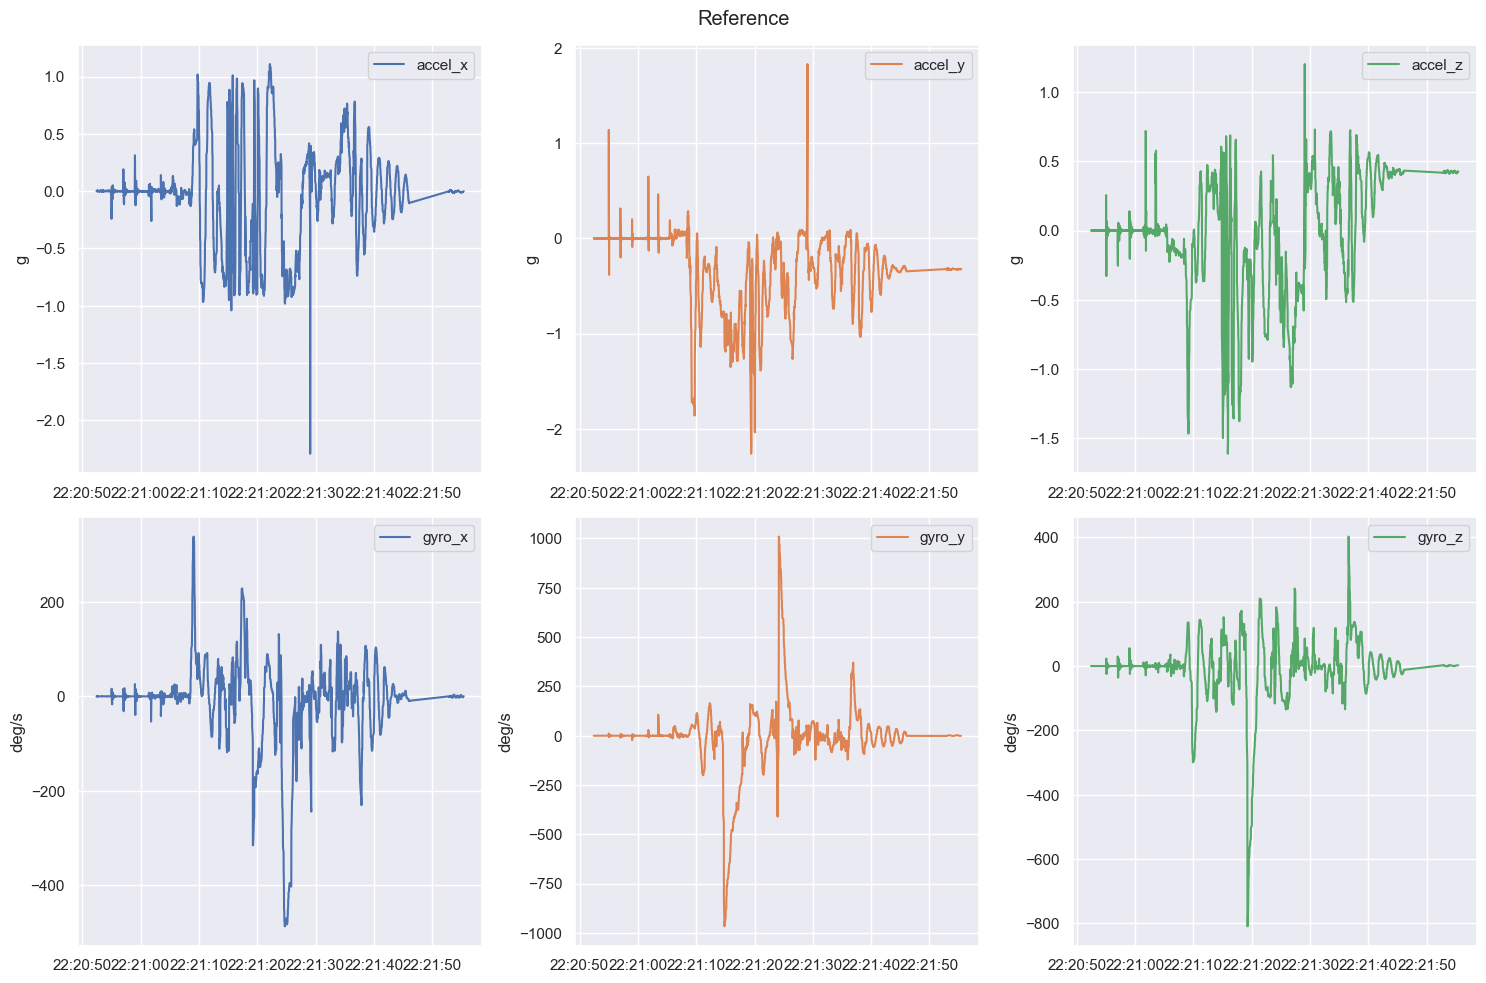

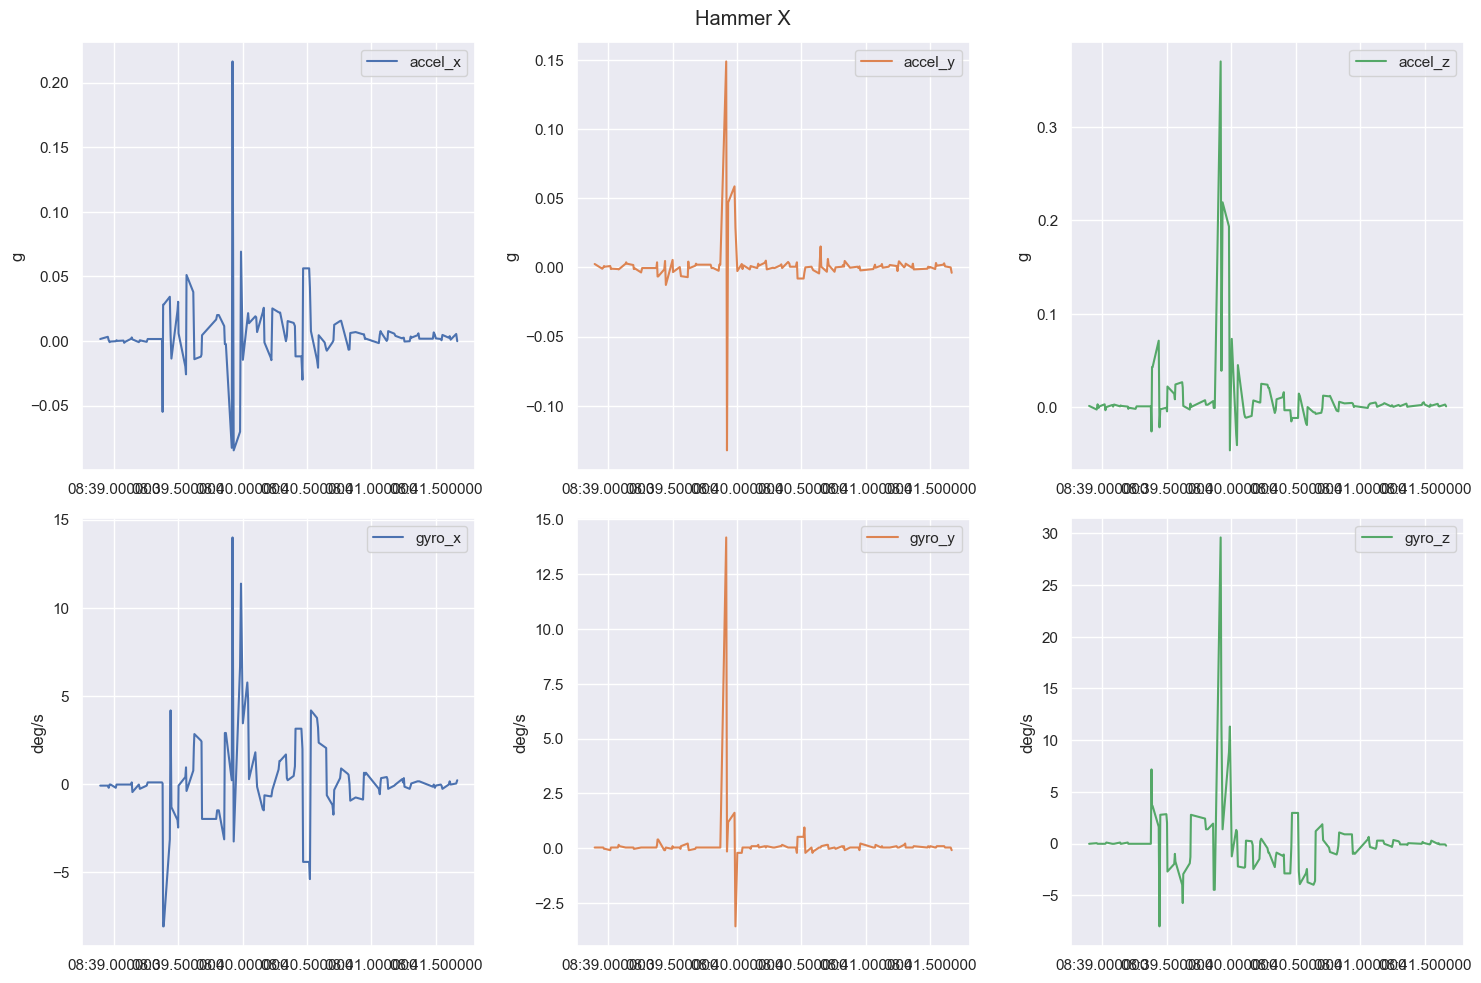

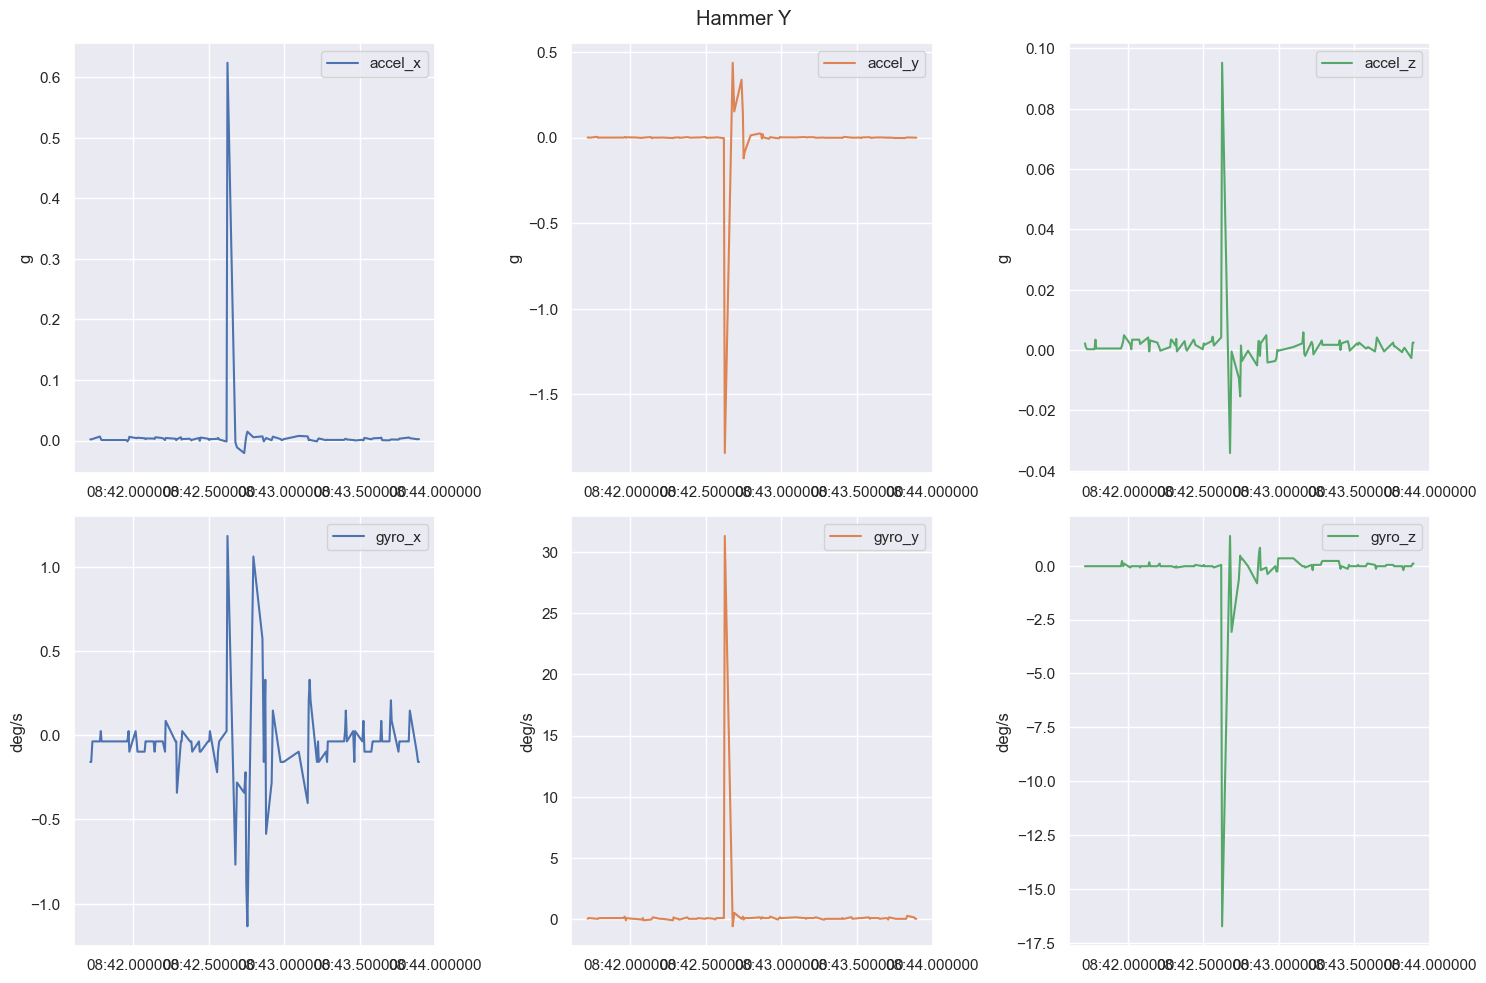

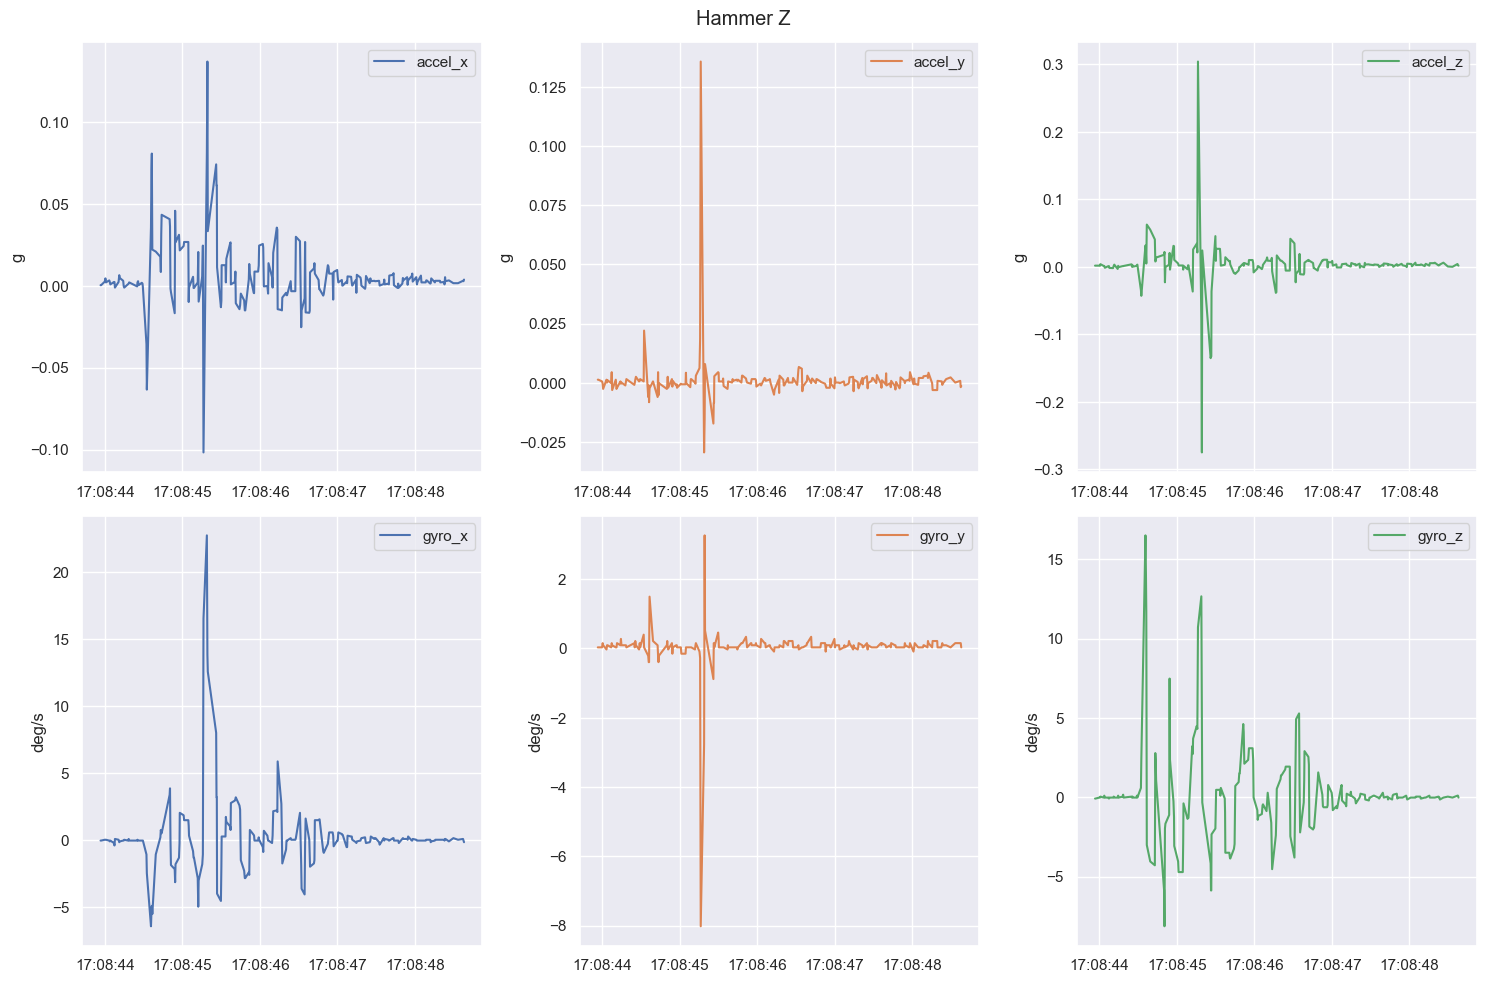

In [12]:
# plot reference data
plot_sensors_df(df_ref, "Reference", x_index='_time')

# plot all the actions

# plot_sensors_df(df_floatingx, "Floating X", x_index='_time')
# plot_sensors_df(df_floatingy, "Floating Y", x_index='_time')
# plot_sensors_df(df_floatingz, "Floating Z", x_index='_time')
plot_sensors_df(df_hammerx, "Hammer X", x_index='_time')
plot_sensors_df(df_hammery, "Hammer Y", x_index='_time')
plot_sensors_df(df_hammerz, "Hammer Z", x_index='_time')
# plot_sensors_df(df_impactx, "Impact X", x_index='_time')
# plot_sensors_df(df_impacty, "Impact Y", x_index='_time')
# plot_sensors_df(df_impactz, "Impact Z", x_index='_time')
# plot_sensors_df(df_rotationx, "Rotation X", x_index='_time')
# plot_sensors_df(df_rotationy, "Rotation Y", x_index='_time')
# plot_sensors_df(df_rotationz, "Rotation Z", x_index='_time')

Re-sampling

In [14]:
# resample the dataset to 0.01s
sampling_time = 0.01

# keep only columns=['_time', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
columns=['_time', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'quat_x', 'quat_y', 'quat_z', 'quat_w']
df_ref_over = df_ref[columns].copy()
df_floatinx_over = df_floatingx[columns].copy()
df_floatiny_over = df_floatingy[columns].copy()
df_floatinz_over = df_floatingz[columns].copy()
df_hammerx_over = df_hammerx[columns].copy()
df_hammery_over = df_hammery[columns].copy()
df_hammerz_over = df_hammerz[columns].copy()
df_impactx_over = df_impactx[columns].copy()
df_impacty_over = df_impacty[columns].copy()
df_impactz_over = df_impactz[columns].copy()
df_rotationx_over = df_rotationx[columns].copy()
df_rotationy_over = df_rotationy[columns].copy()
df_rotationz_over = df_rotationz[columns].copy()

# resample the dataset
df_ref_over = df_ref_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_floatinx_over = df_floatinx_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_floatiny_over = df_floatiny_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_floatinz_over = df_floatinz_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_hammerx_over = df_hammerx_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_hammery_over = df_hammery_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_hammerz_over = df_hammerz_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_impactx_over = df_impactx_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_impacty_over = df_impacty_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_impactz_over = df_impactz_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_rotationx_over = df_rotationx_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_rotationy_over = df_rotationy_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')
df_rotationz_over = df_rotationz_over.resample(f'{sampling_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')

In [17]:
def plot_fft_peaks(df, sampling_time, title=""):
    
    columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    num_row = math.ceil(len(columns)/3)
    num_col = 3

    num_peaks = 5
    order_peaks = 8

    # create struct to return
    data_struct = {}

    fig, axs = plt.subplots(num_row, num_col, figsize=(15, 10))
    fig.suptitle("FFT with peaks " + title)
    
    for i, column in enumerate(columns):
        # get the fft
        fft_values = fft(df[column].values)
        # get the frequency
        freq = fftfreq(len(df[column].values), d=sampling_time)
        # get the peaks
        peaks = argrelmax(np.abs(fft_values[freq>=0]), order=order_peaks)[0]
        while len(peaks) < num_peaks:
            # reduce the order
            order_peaks = order_peaks - 1
            # get the peaks
            peaks = argrelmax(np.abs(fft_values[freq>=0]), order=order_peaks)[0]
        
        # take the top 5 peaks which are greater than 0
        peaks = peaks[np.argsort(np.abs(fft_values[freq>=0][peaks]))[-5:]]
        # sort the peaks
        peaks.sort()
        # update the struct
        data_struct[column] = {'fft_values': fft_values, 'freq': freq, 'peaks': peaks}

        # plot the fft
        axs[i//3, i%3].plot(freq[freq>=0], np.abs(fft_values[freq>=0]), color='C'+str(i%3), label=column)
        # plot the peaks
        axs[i//3, i%3].plot(freq[peaks], np.abs(fft_values[freq>=0][peaks]), 'x', color='red', label='peaks')
        axs[i//3, i%3].legend()

        # set the y label
        if 'accel' in column:
            axs[i//3, i%3].set_ylabel('g')
        else:
            axs[i//3, i%3].set_ylabel('deg/s')
    
    return data_struct

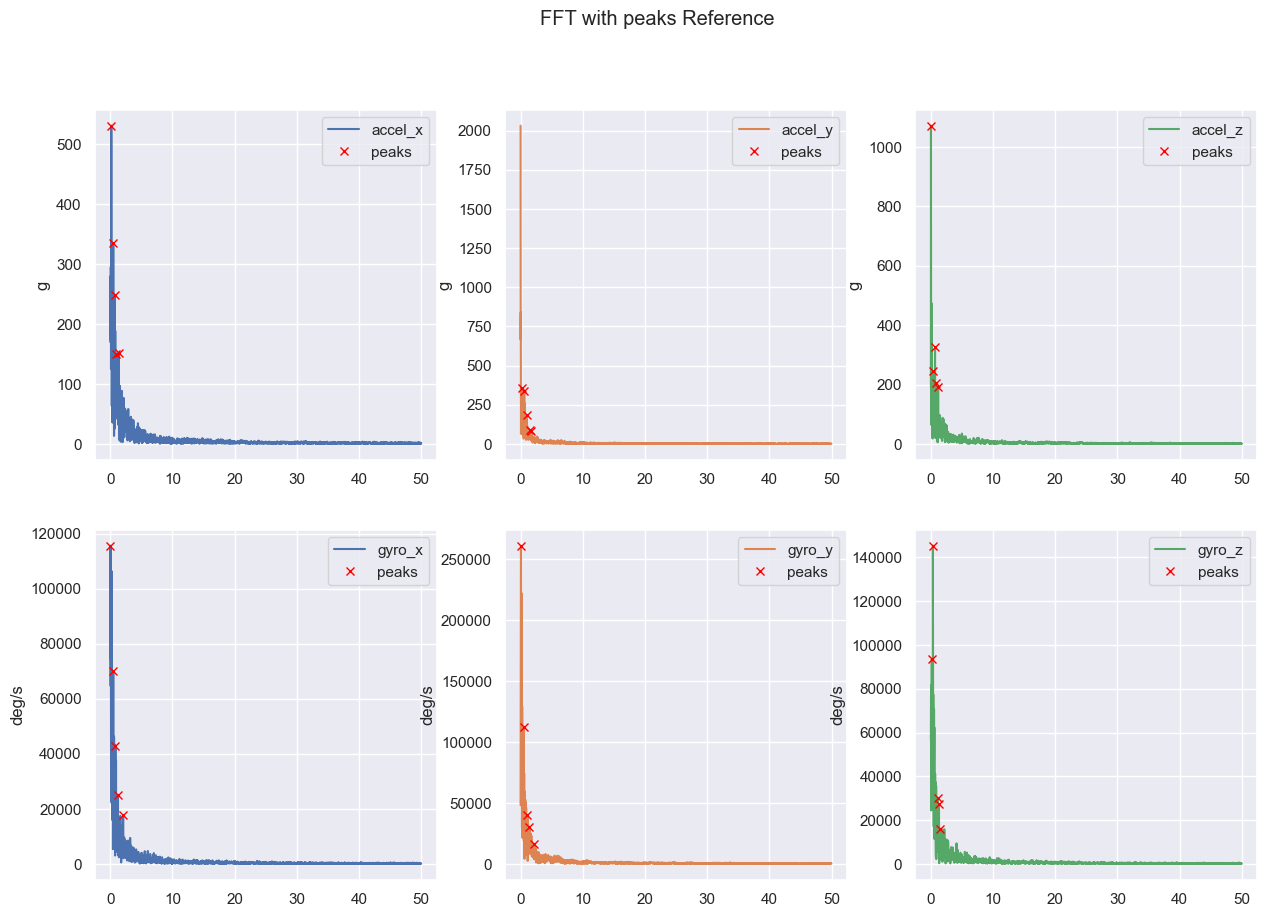

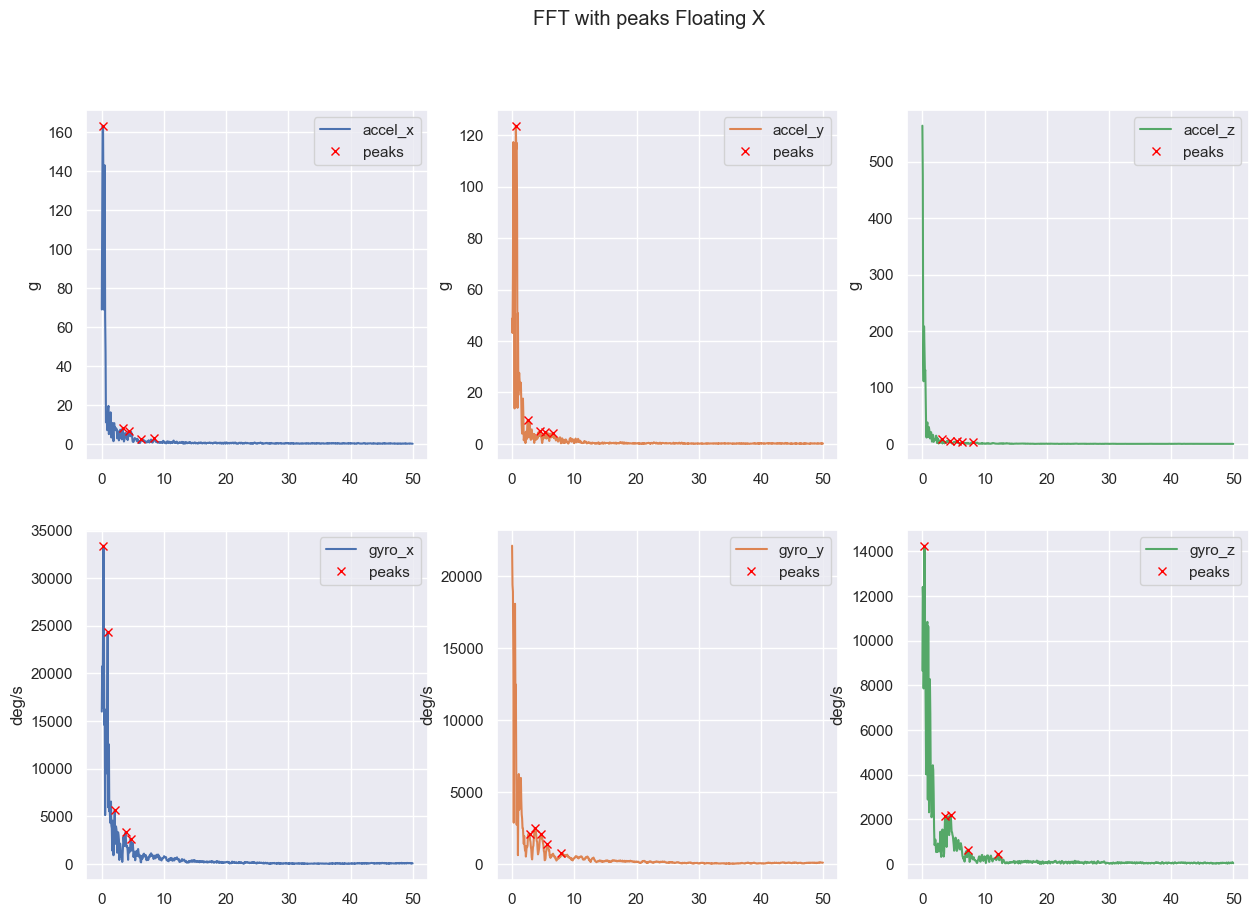

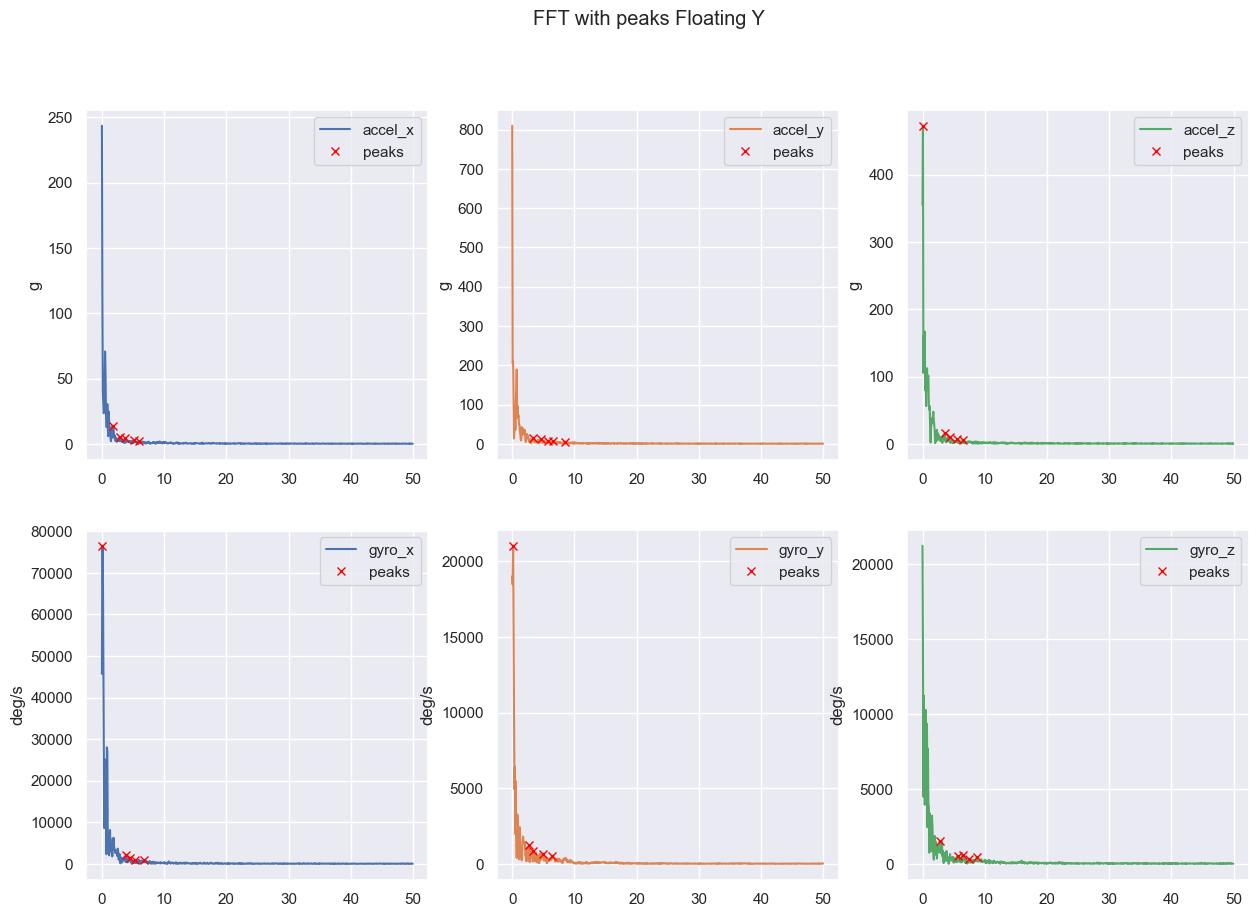

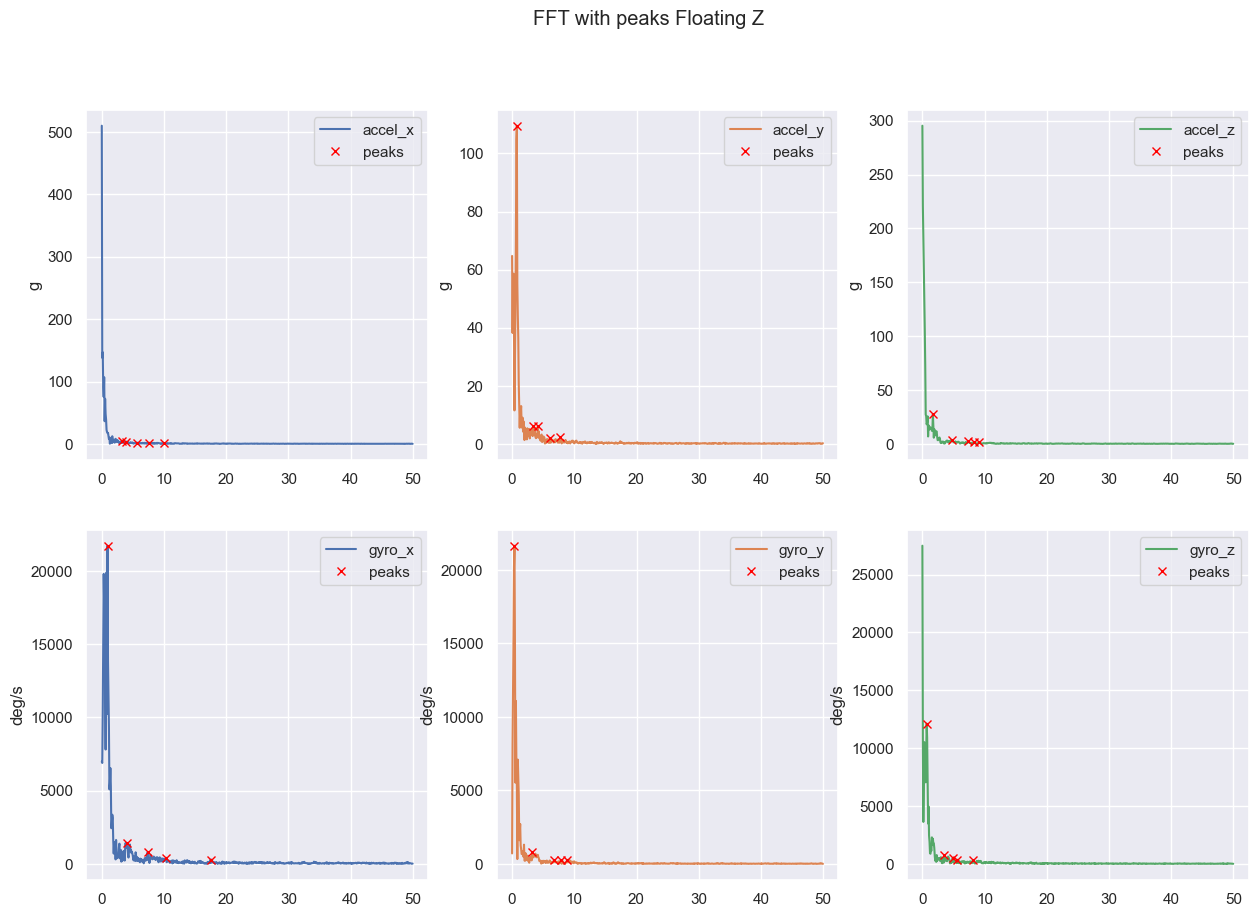

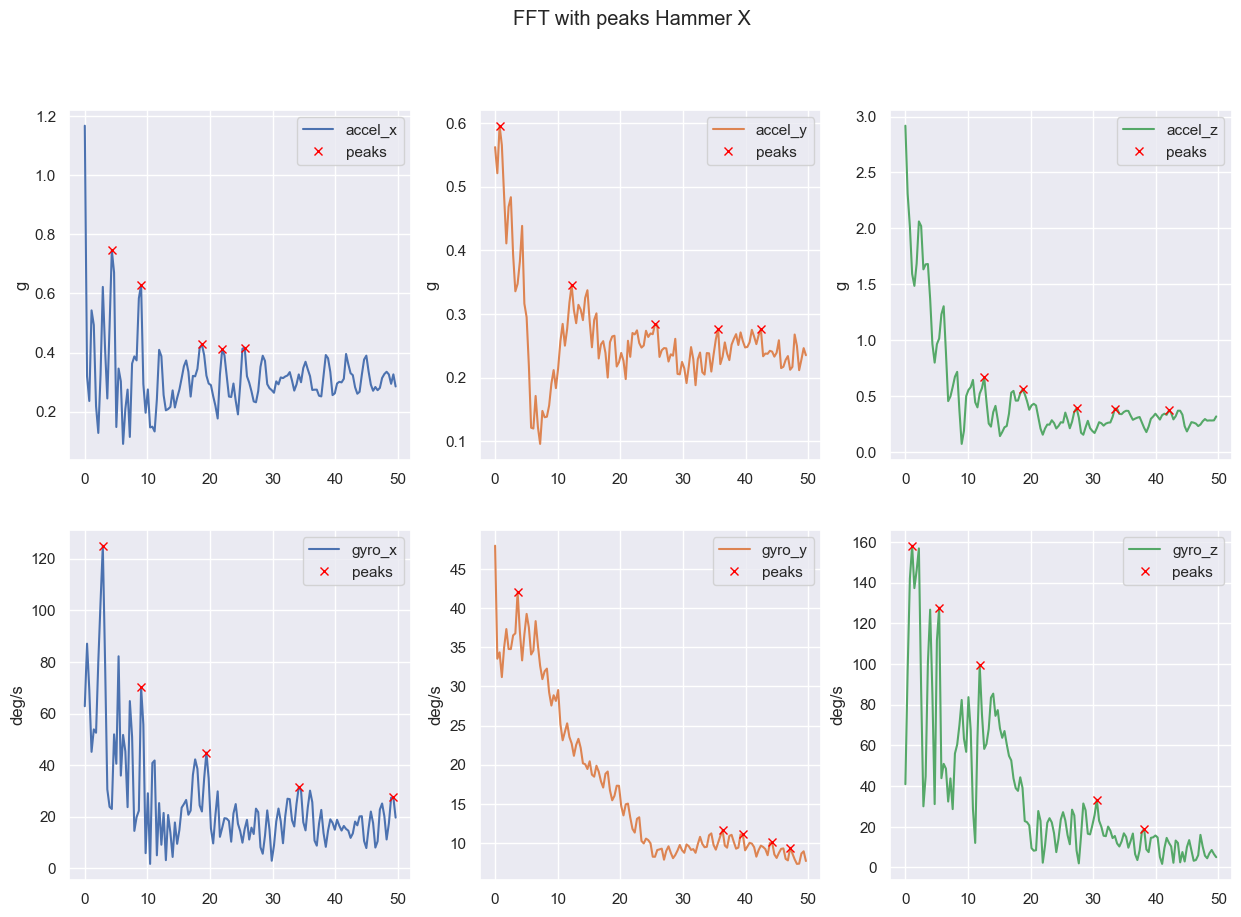

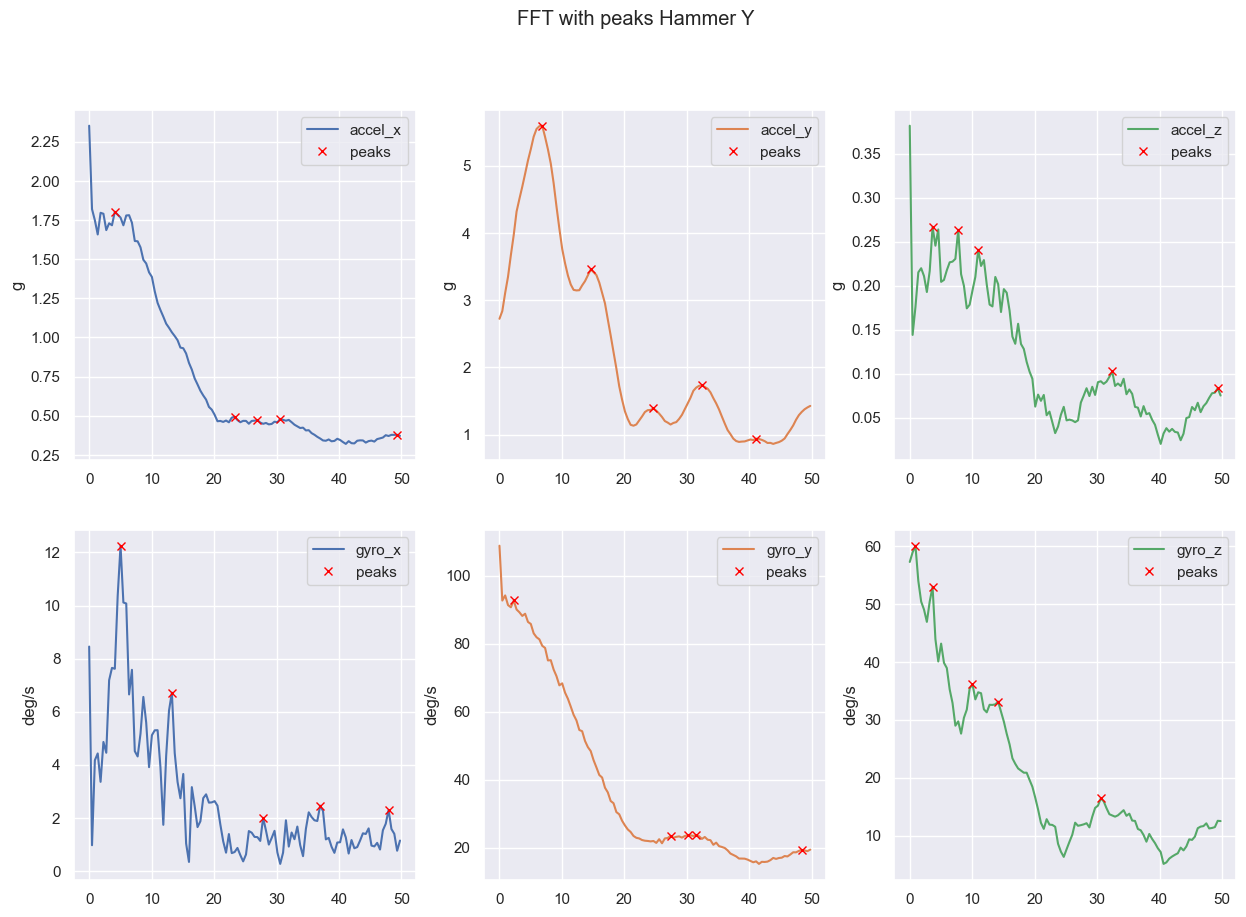

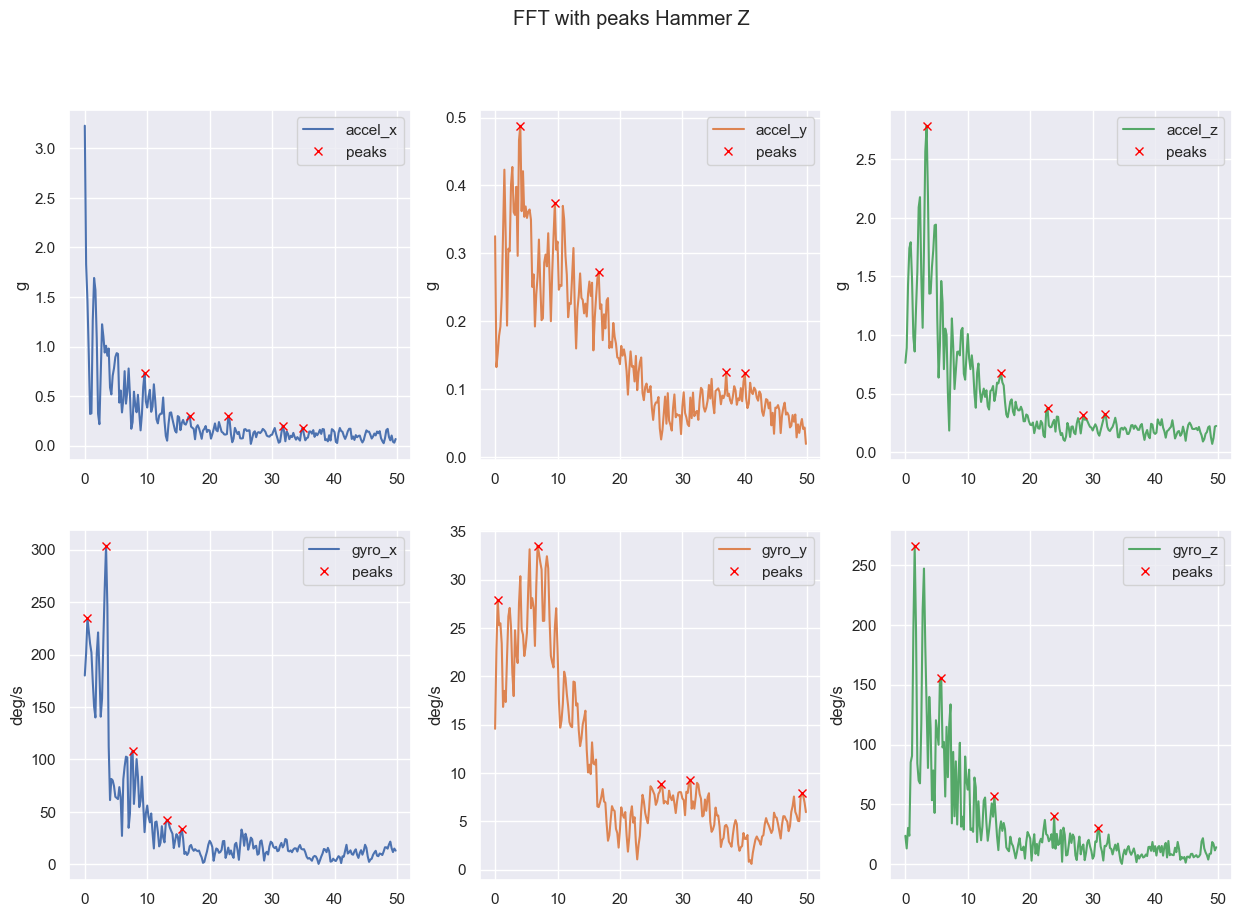

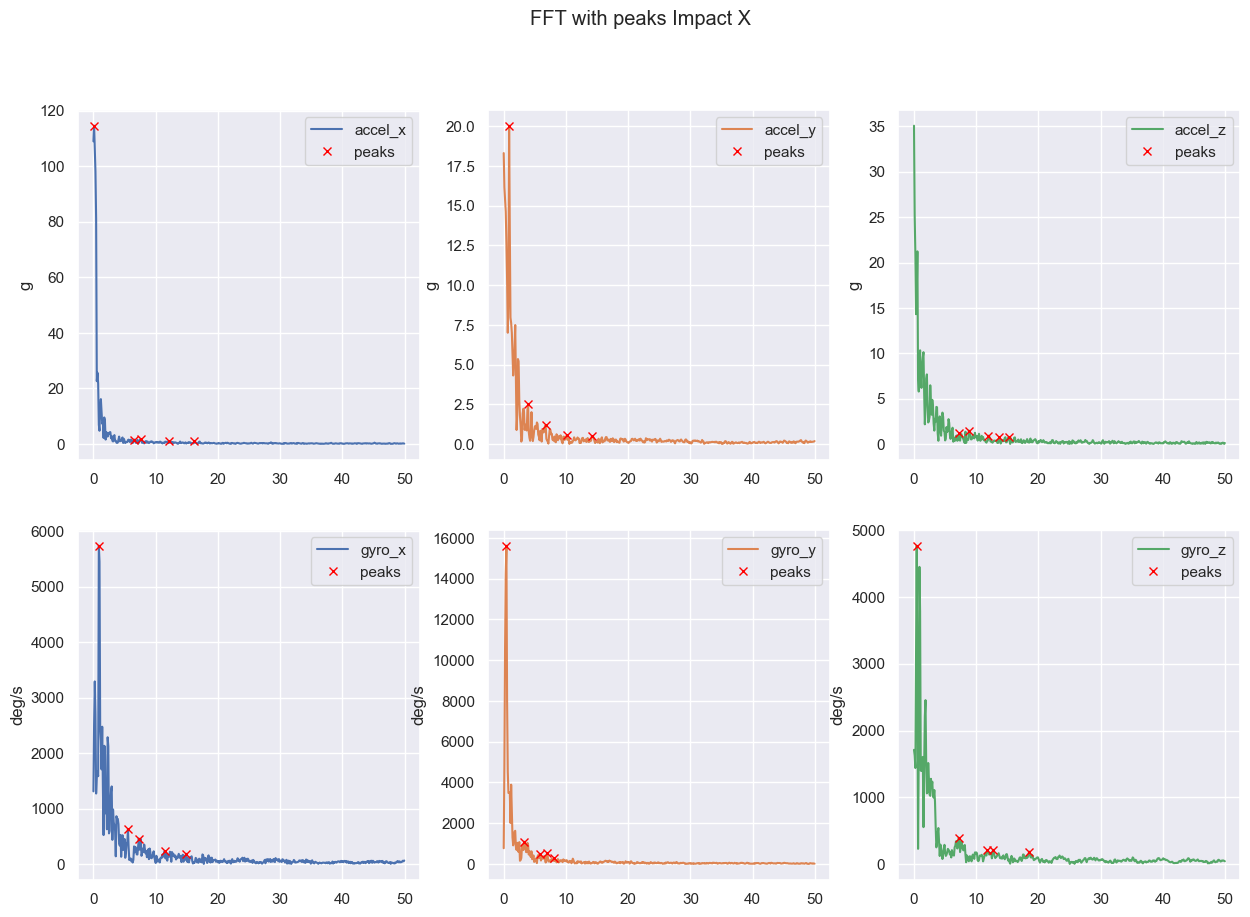

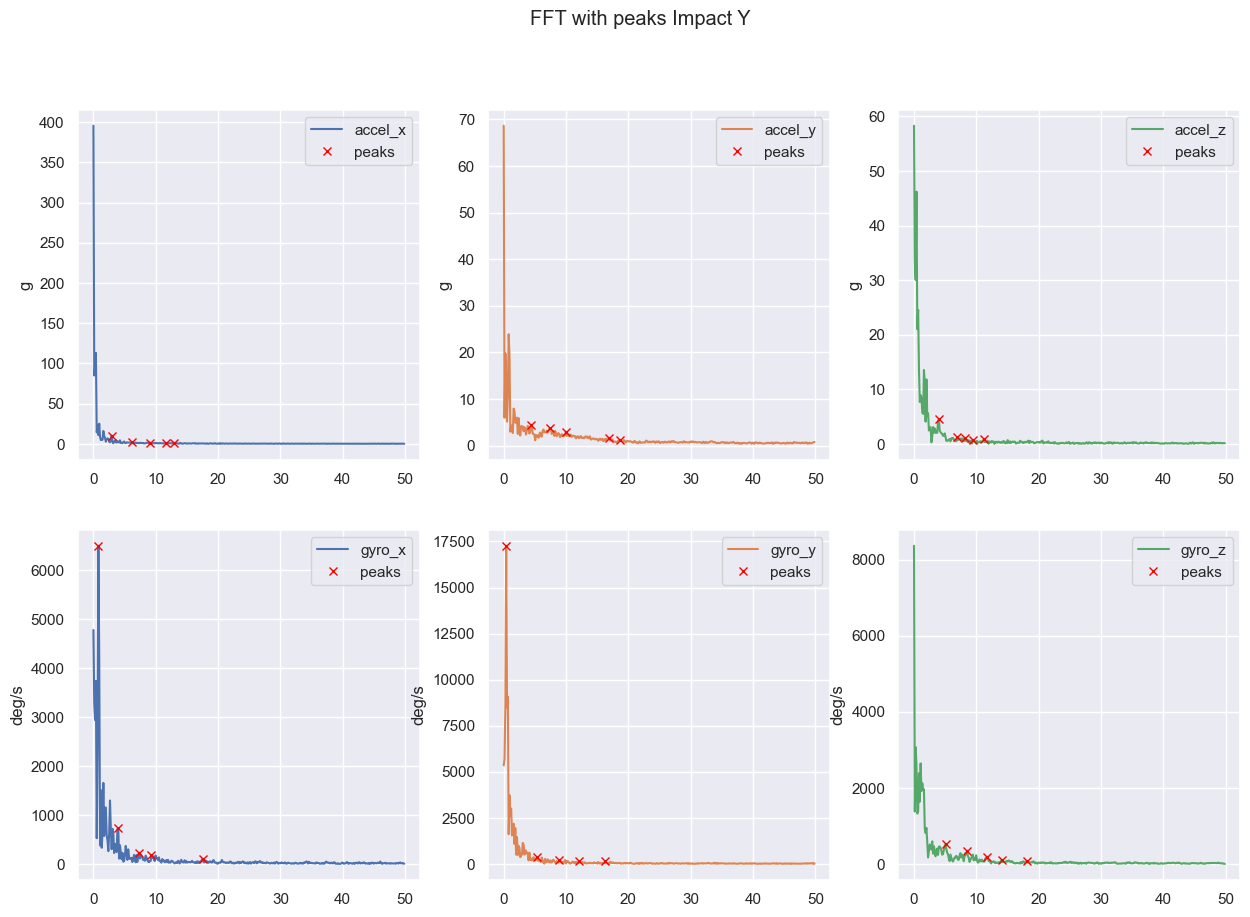

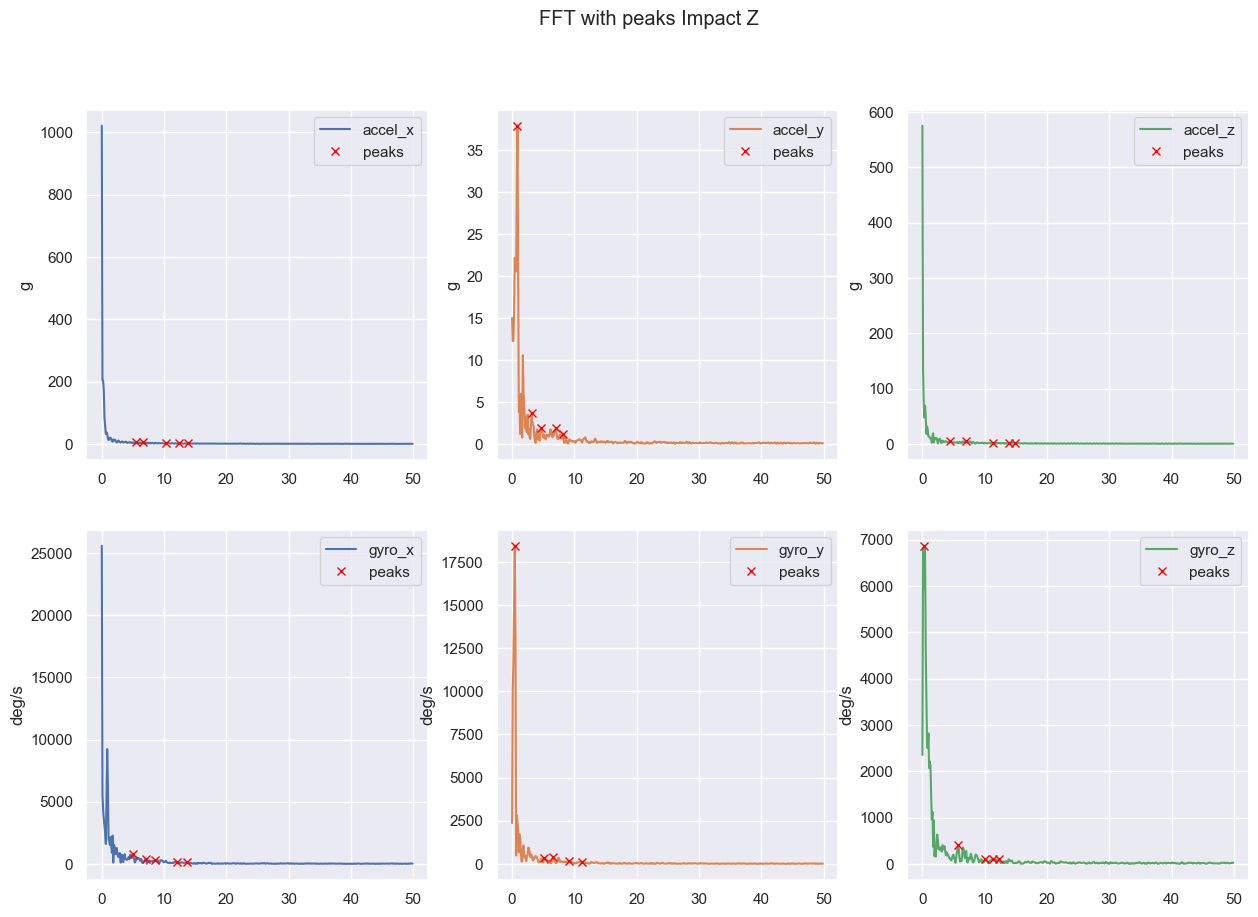

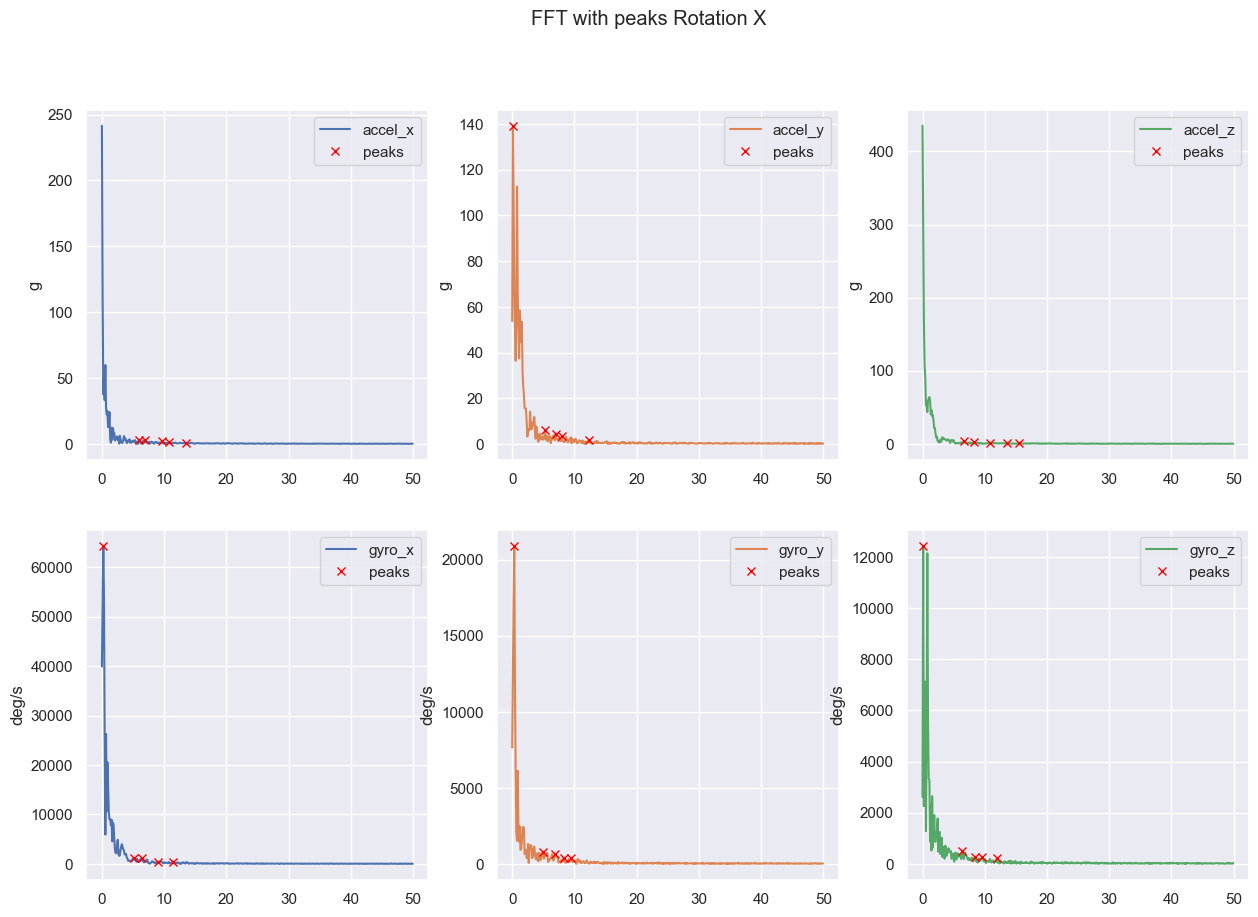

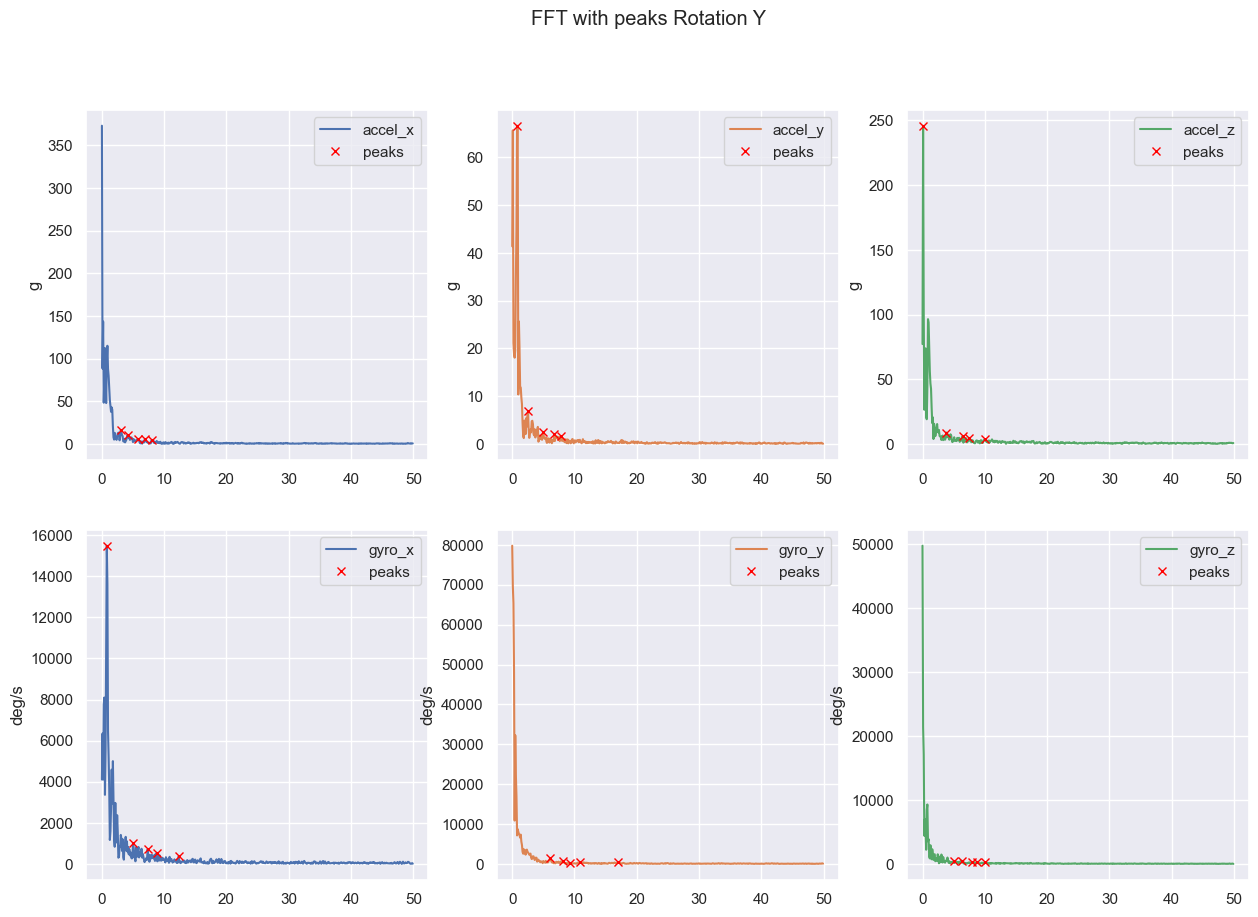

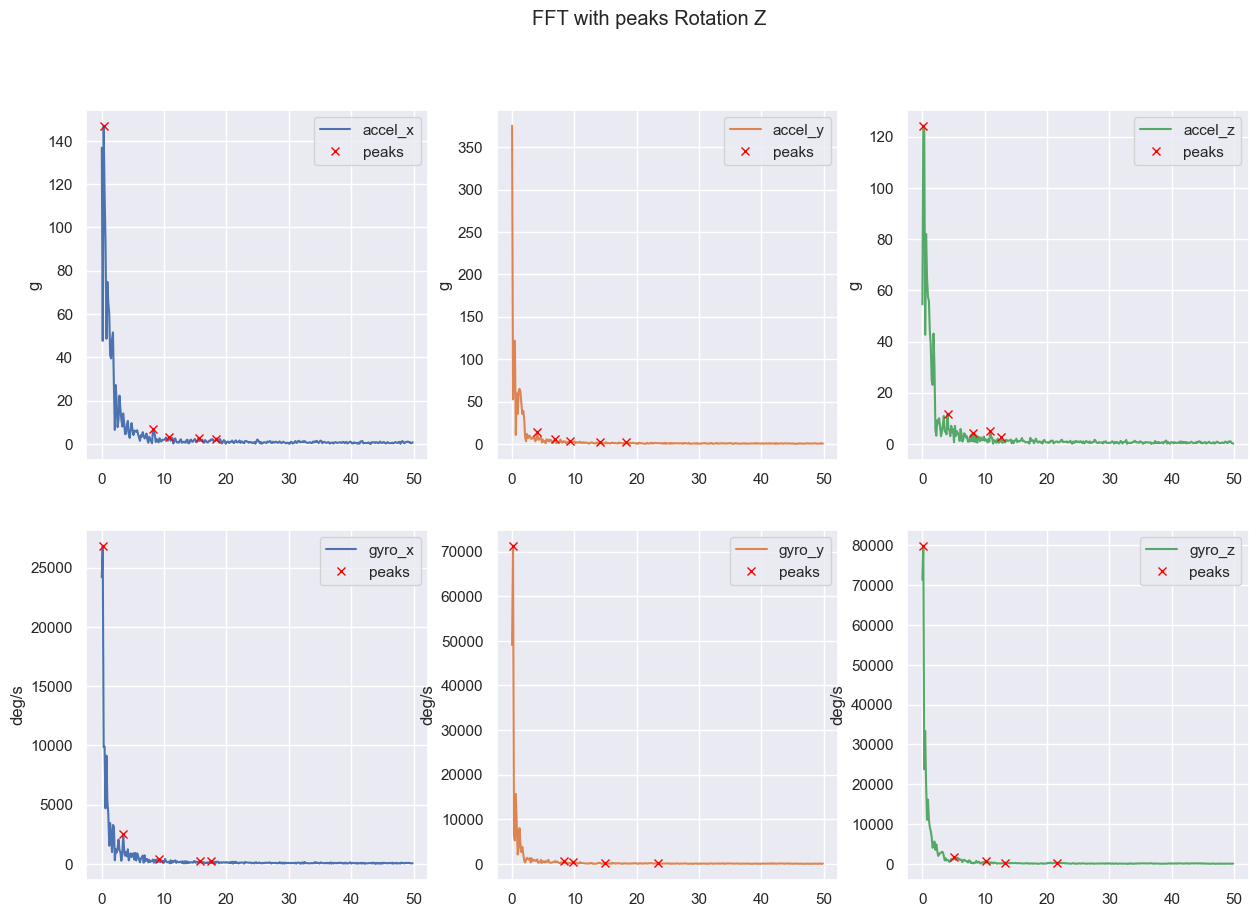

In [18]:
ref_fft = plot_fft_peaks(df_ref_over, sampling_time, title="Reference")
floatingx_fft = plot_fft_peaks(df_floatinx_over, sampling_time, title="Floating X")
floatingy_fft = plot_fft_peaks(df_floatiny_over, sampling_time, title="Floating Y")
floatingz_fft = plot_fft_peaks(df_floatinz_over, sampling_time, title="Floating Z")
hammerx_fft = plot_fft_peaks(df_hammerx_over, sampling_time, title="Hammer X")
hammery_fft = plot_fft_peaks(df_hammery_over, sampling_time, title="Hammer Y")
hammerz_fft = plot_fft_peaks(df_hammerz_over, sampling_time, title="Hammer Z")
impactx_fft = plot_fft_peaks(df_impactx_over, sampling_time, title="Impact X")
impacty_fft = plot_fft_peaks(df_impacty_over, sampling_time, title="Impact Y")
impactz_fft = plot_fft_peaks(df_impactz_over, sampling_time, title="Impact Z")
rotationx_fft = plot_fft_peaks(df_rotationx_over, sampling_time, title="Rotation X")
rotationy_fft = plot_fft_peaks(df_rotationy_over, sampling_time, title="Rotation Y")
rotationz_fft = plot_fft_peaks(df_rotationz_over, sampling_time, title="Rotation Z")

In [19]:
def plot_stem_peaks(sensor_fft, title=""):

    columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    num_row = math.ceil(len(columns)/3)
    num_col = 3

    fig, axs = plt.subplots(num_row, num_col, figsize=(15, 10))
    fig.suptitle("FFT Peaks - "+title)

    for i, column in enumerate(columns):
        # stem plot
        axs[i//3, i%3].stem(sensor_fft[column]['freq'][sensor_fft[column]['peaks']], np.abs(sensor_fft[column]['fft_values'][sensor_fft[column]['peaks']]), label=column, basefmt='C'+str(i%3), linefmt='C'+str(i%3))
        axs[i//3, i%3].plot(sensor_fft[column]['freq'][sensor_fft[column]['peaks']], np.abs(sensor_fft[column]['fft_values'][sensor_fft[column]['peaks']]), label=column, color='C'+str(i%3), alpha=0.5)
        
        # set the y label
        if 'accel' in column:
            axs[i//3, i%3].set_ylabel('g')
        else:
            axs[i//3, i%3].set_ylabel('deg/s')
            axs[i//3, i%3].set_xlabel('Hz')

        axs[i//3, i%3].legend()


    # give more space between the subplots
    fig.tight_layout(pad=1.0)
    plt.show()

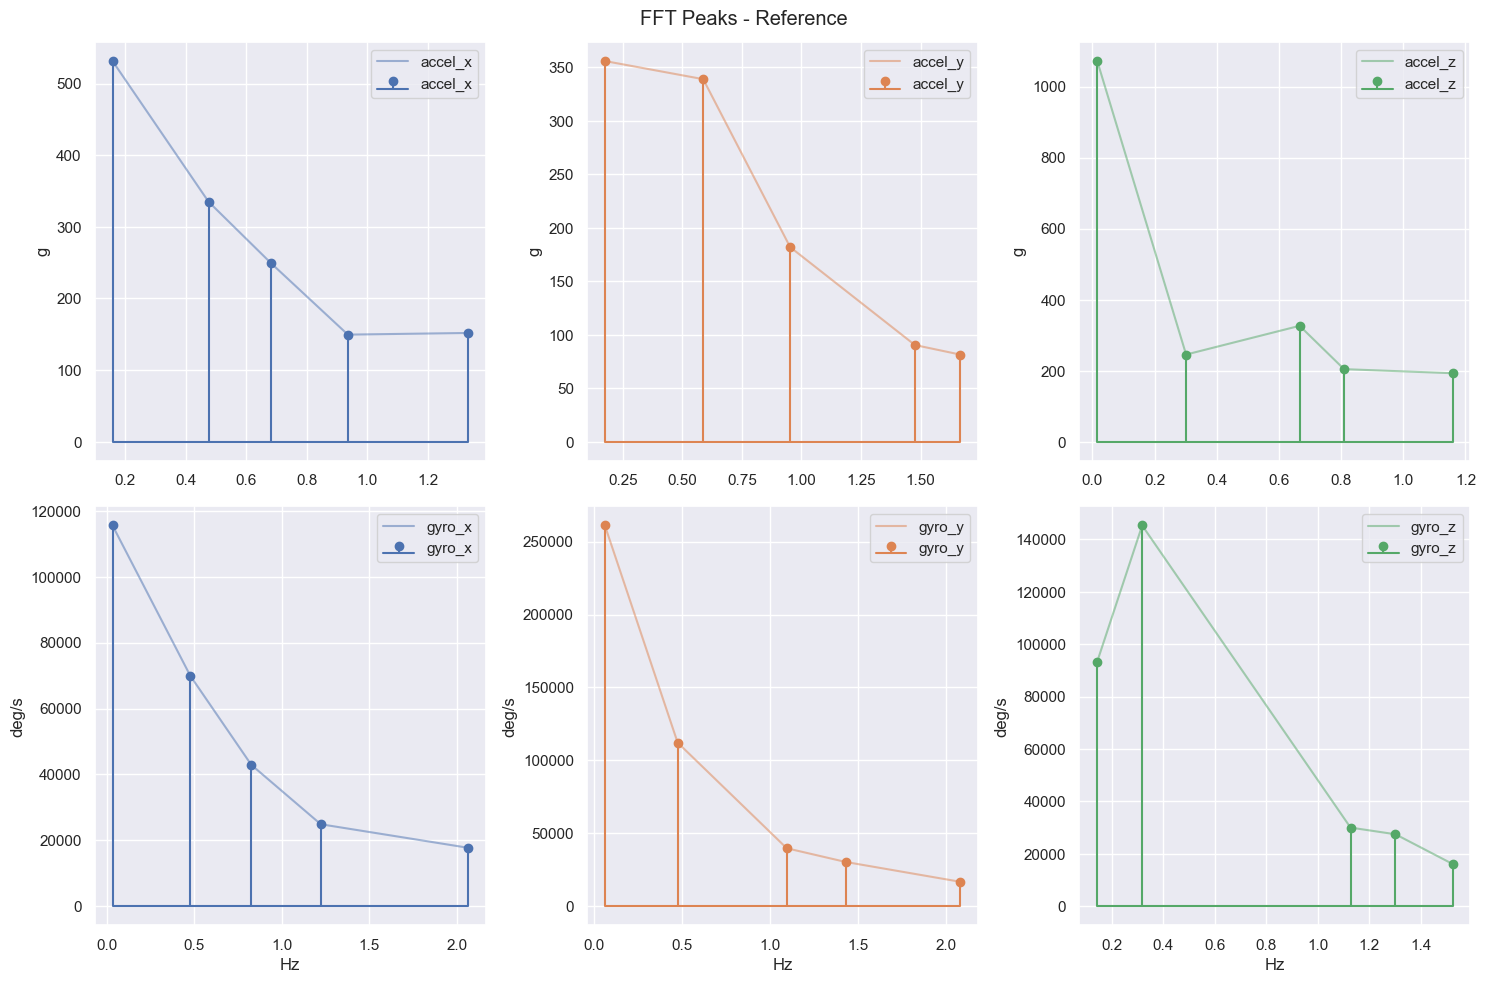

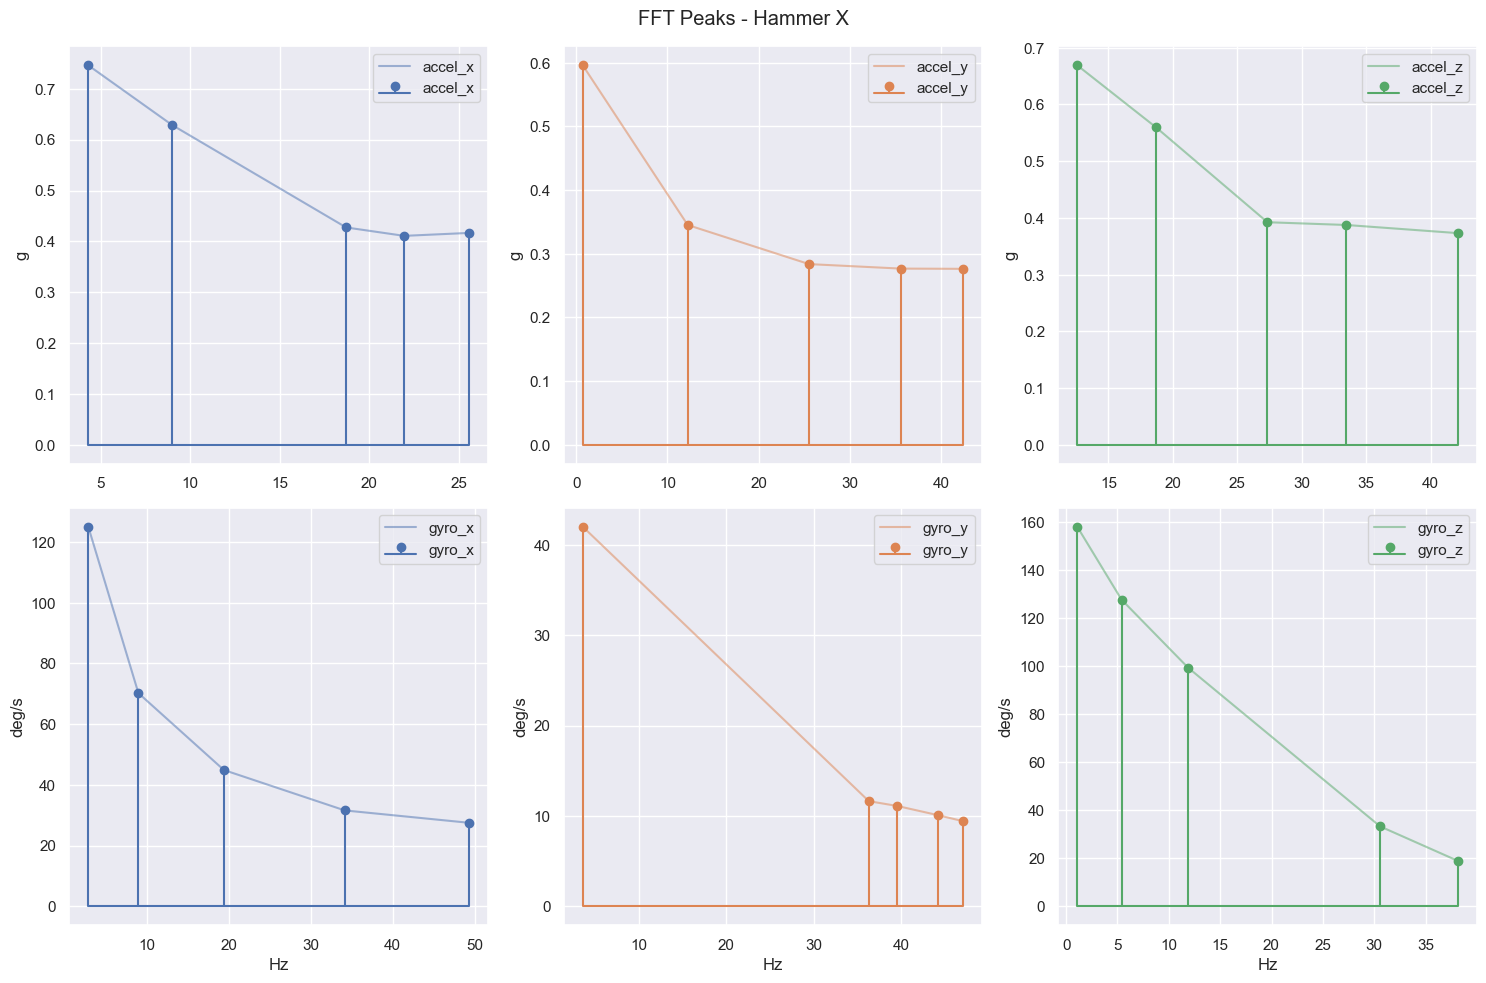

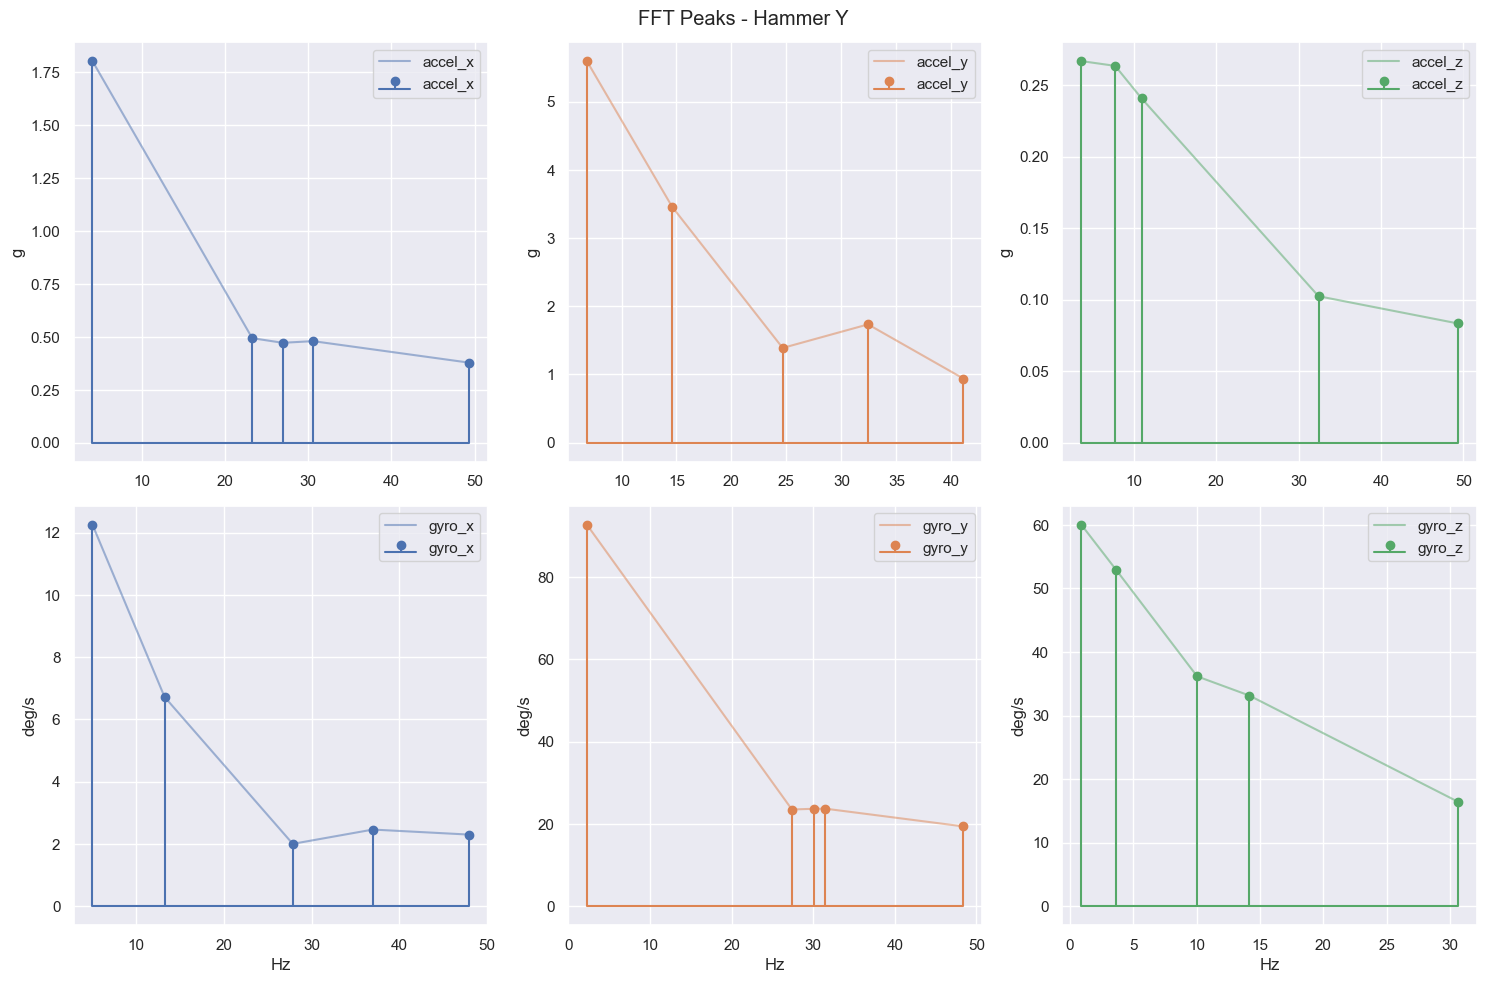

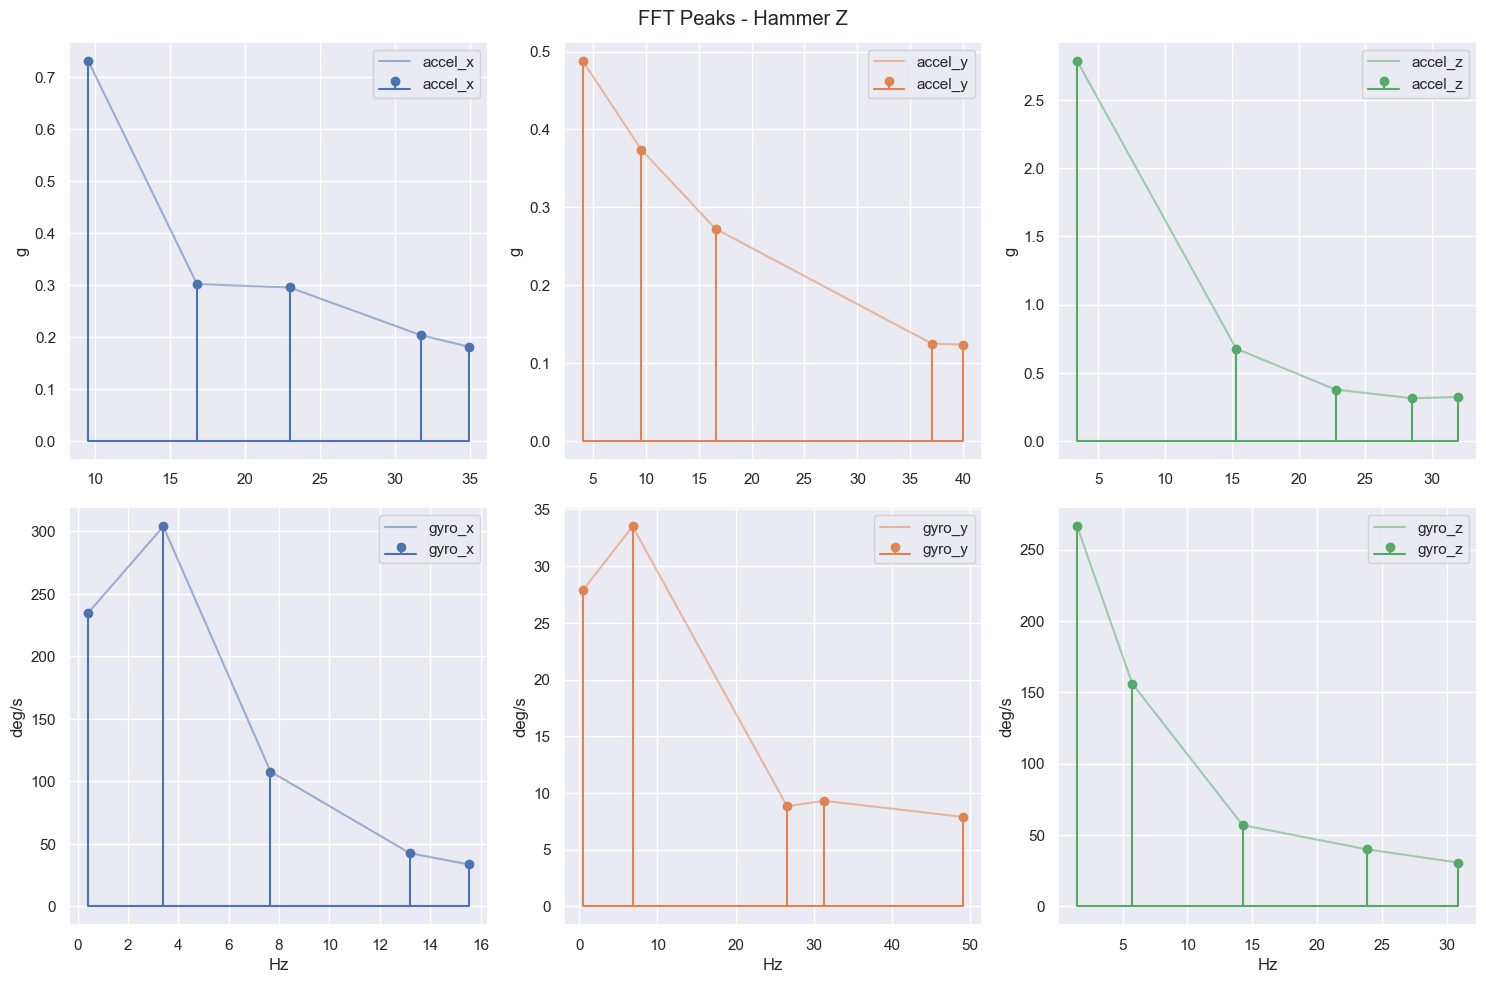

In [21]:
plot_stem_peaks(ref_fft, title="Reference")
# plot_stem_peaks(floatingx_fft, title="Floating X")
# plot_stem_peaks(floatingy_fft, title="Floating Y")
# plot_stem_peaks(floatingz_fft, title="Floating Z")
plot_stem_peaks(hammerx_fft, title="Hammer X")
plot_stem_peaks(hammery_fft, title="Hammer Y")
plot_stem_peaks(hammerz_fft, title="Hammer Z")
# plot_stem_peaks(impactx_fft, title="Impact X")
# plot_stem_peaks(impacty_fft, title="Impact Y")
# plot_stem_peaks(impactz_fft, title="Impact Z")
# plot_stem_peaks(rotationx_fft, title="Rotation X")
# plot_stem_peaks(rotationy_fft, title="Rotation Y")
# plot_stem_peaks(rotationz_fft, title="Rotation Z")

In [22]:
def plot_peaks_combined(sensor_fft, title=""):

    columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    num_row = math.ceil(len(columns)/3)
    num_col = 1

    fig, axs = plt.subplots(num_row, num_col, figsize=(15, 10))
    fig.suptitle("FFT Peaks Concatenated - "+title)

    accel_fft = []
    accel_freq = []
    gyro_fft = []
    gyro_freq = []

    for i, column in enumerate(columns):
        freq = sensor_fft[column]['freq'][sensor_fft[column]['peaks']]
        fft_values = np.abs(sensor_fft[column]['fft_values'][sensor_fft[column]['peaks']])
 
        # set the y label
        if 'accel' in column:
            accel_freq.append(freq)
            accel_fft.append(fft_values)
        else:
            gyro_freq.append(freq)
            gyro_fft.append(fft_values)

    # concat the accel and gyro
    accel_freq = np.concatenate(accel_freq)
    accel_fft = np.concatenate(accel_fft)
    gyro_freq = np.concatenate(gyro_freq)
    gyro_fft = np.concatenate(gyro_fft)
    
    # sort the accel and gyro
    accel = zip(accel_freq, accel_fft)
    gyro = zip(gyro_freq, gyro_fft)
    accel = sorted(accel, key=lambda x: x[0])
    gyro = sorted(gyro, key=lambda x: x[0])

    accel_freq, accel_fft = zip(*accel)
    gyro_freq, gyro_fft = zip(*gyro)

    # plot the accel
    axs[0].stem(accel_freq, accel_fft, label='accel_xyz', basefmt='C0', linefmt='C0')
    axs[0].plot(accel_freq, accel_fft, label='accel_xyz', color='C0', alpha=0.5)
    # plot the gyro
    axs[1].stem(gyro_freq, gyro_fft, label='gyro_xyz', basefmt='C1', linefmt='C1')
    axs[1].plot(gyro_freq, gyro_fft, label='gyro_xyz', color='C1', alpha=0.5)

    axs[0].set_ylabel('g')
    axs[1].set_ylabel('deg/s')
    axs[1].set_xlabel('Hz')

    axs[0].legend()
    axs[1].legend()
    # give more space between the subplots
    fig.tight_layout(pad=1.0)
    plt.show()

    return np.array(list(zip(accel_freq, accel_fft))), np.array(list(zip(gyro_freq, gyro_fft)))

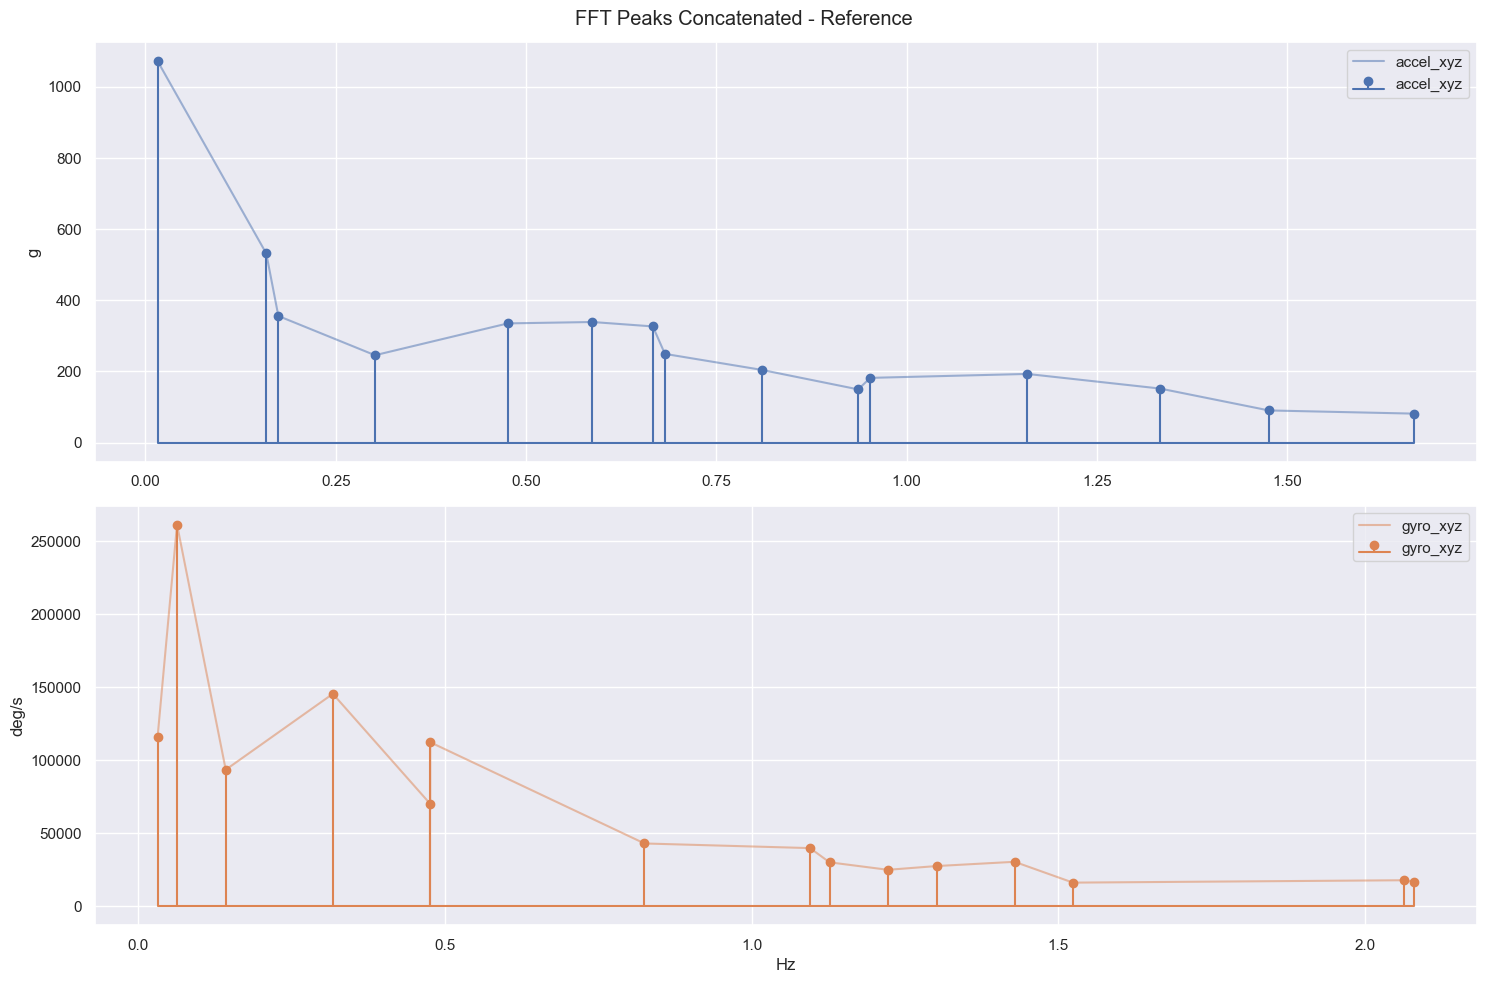

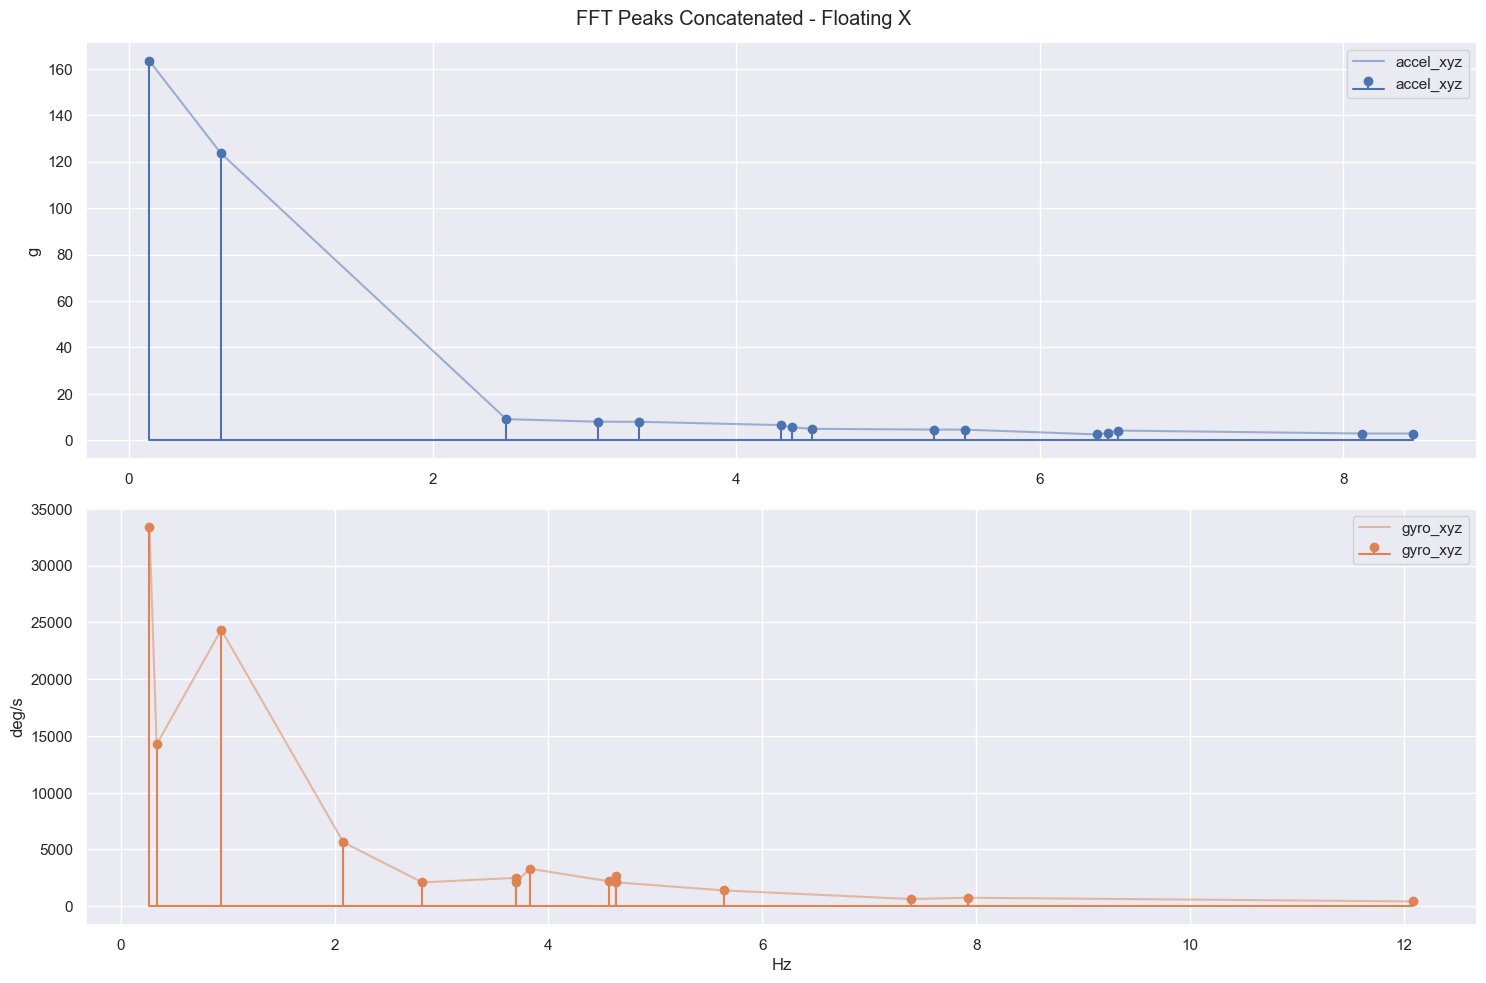

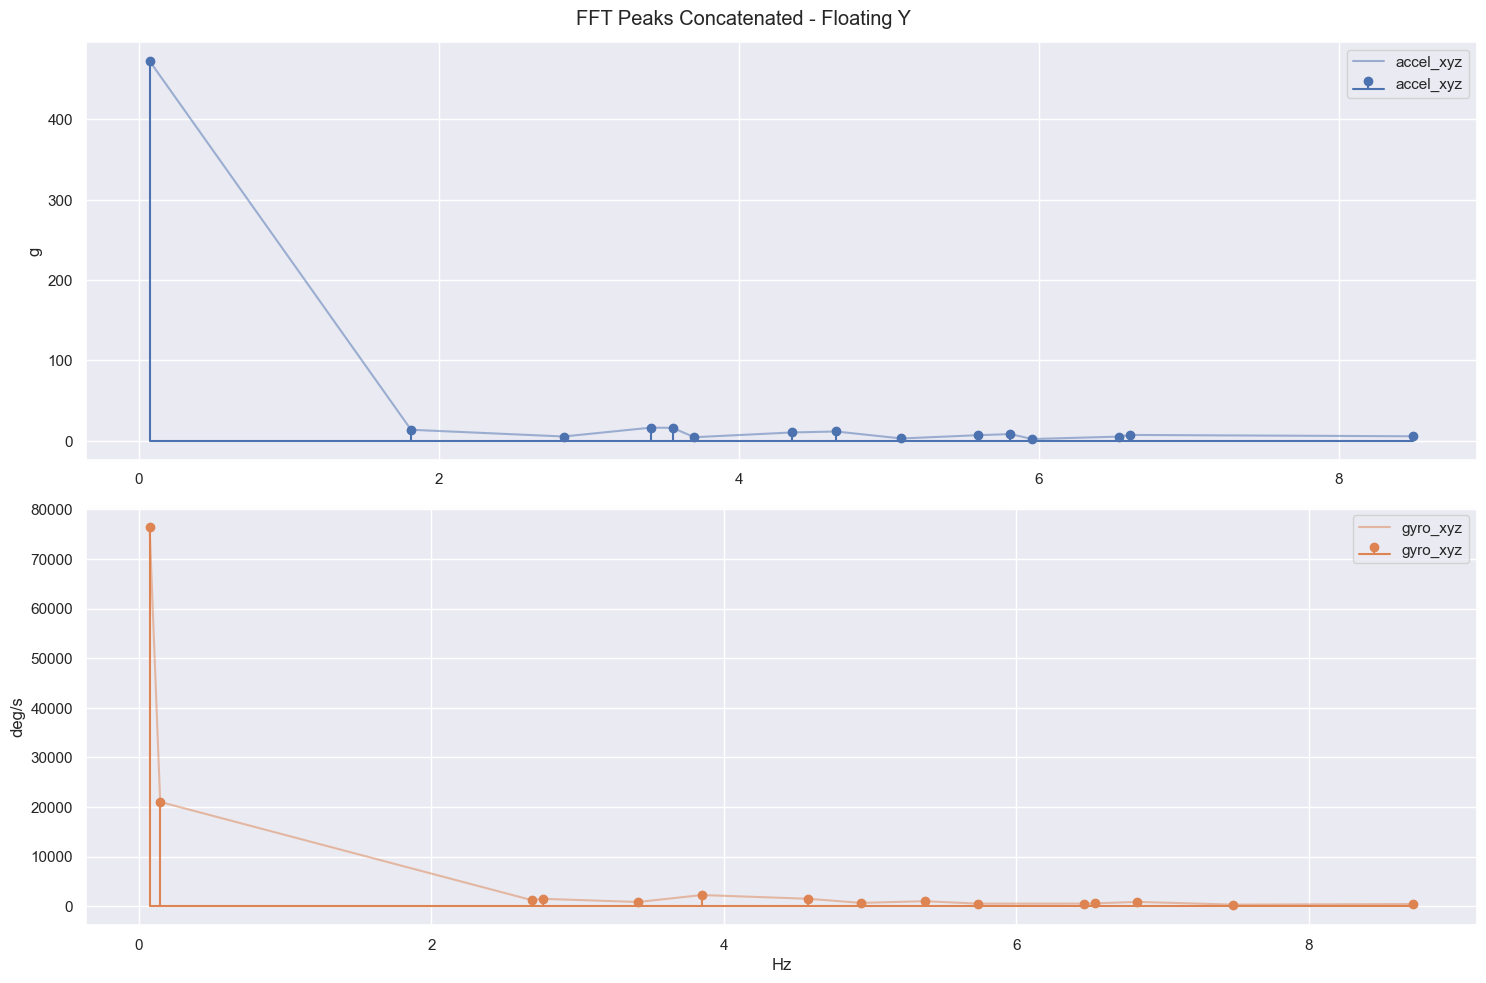

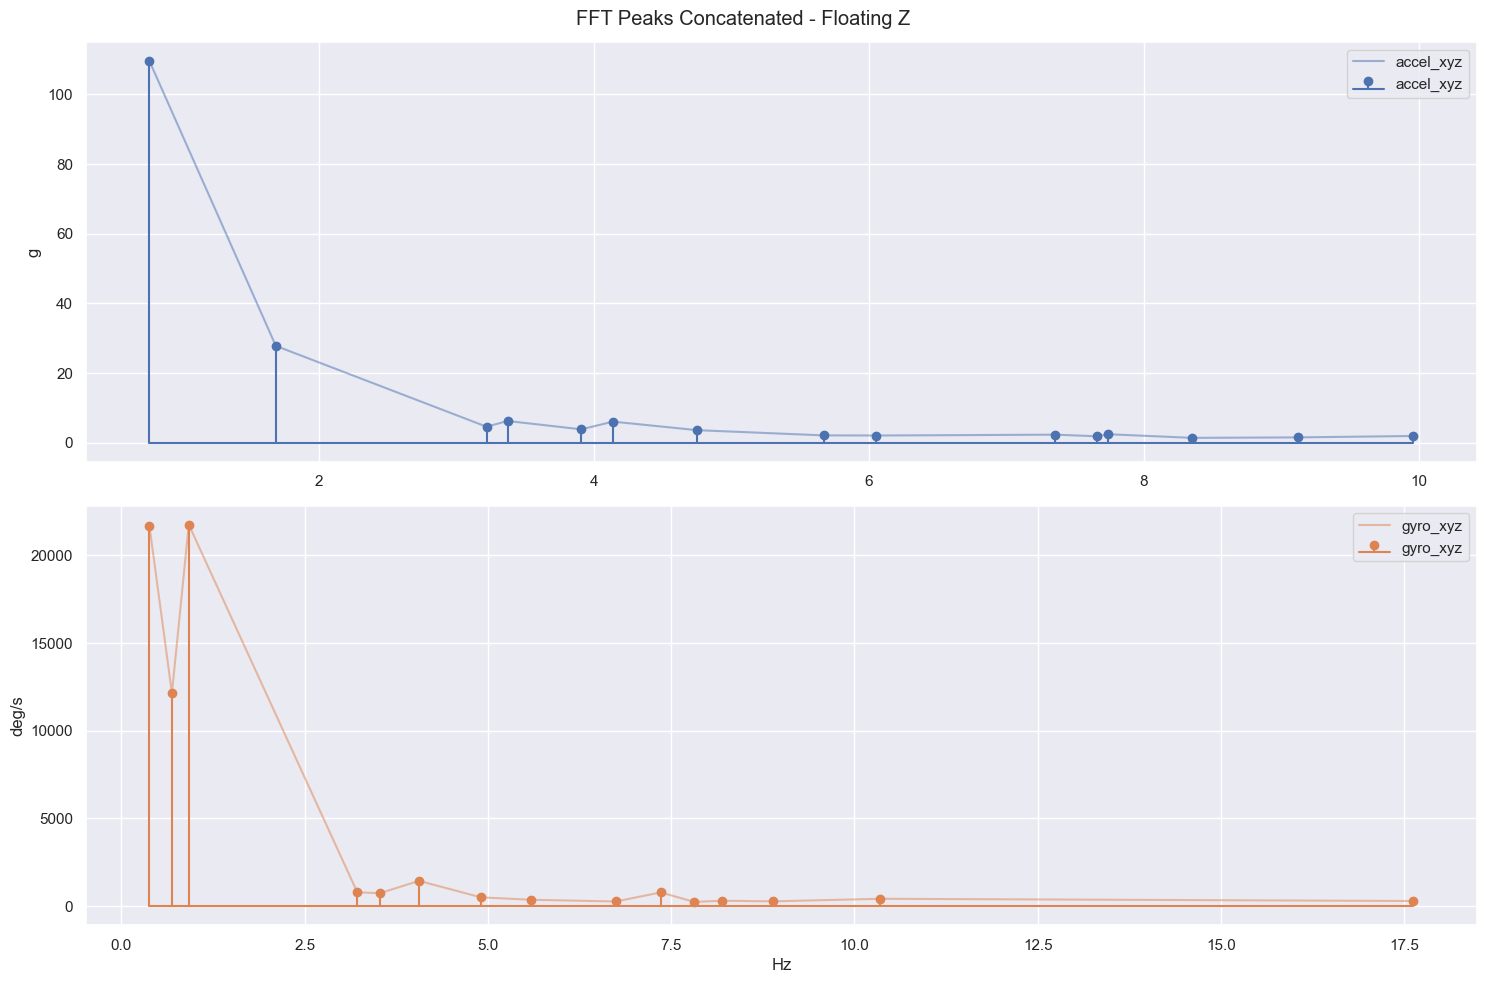

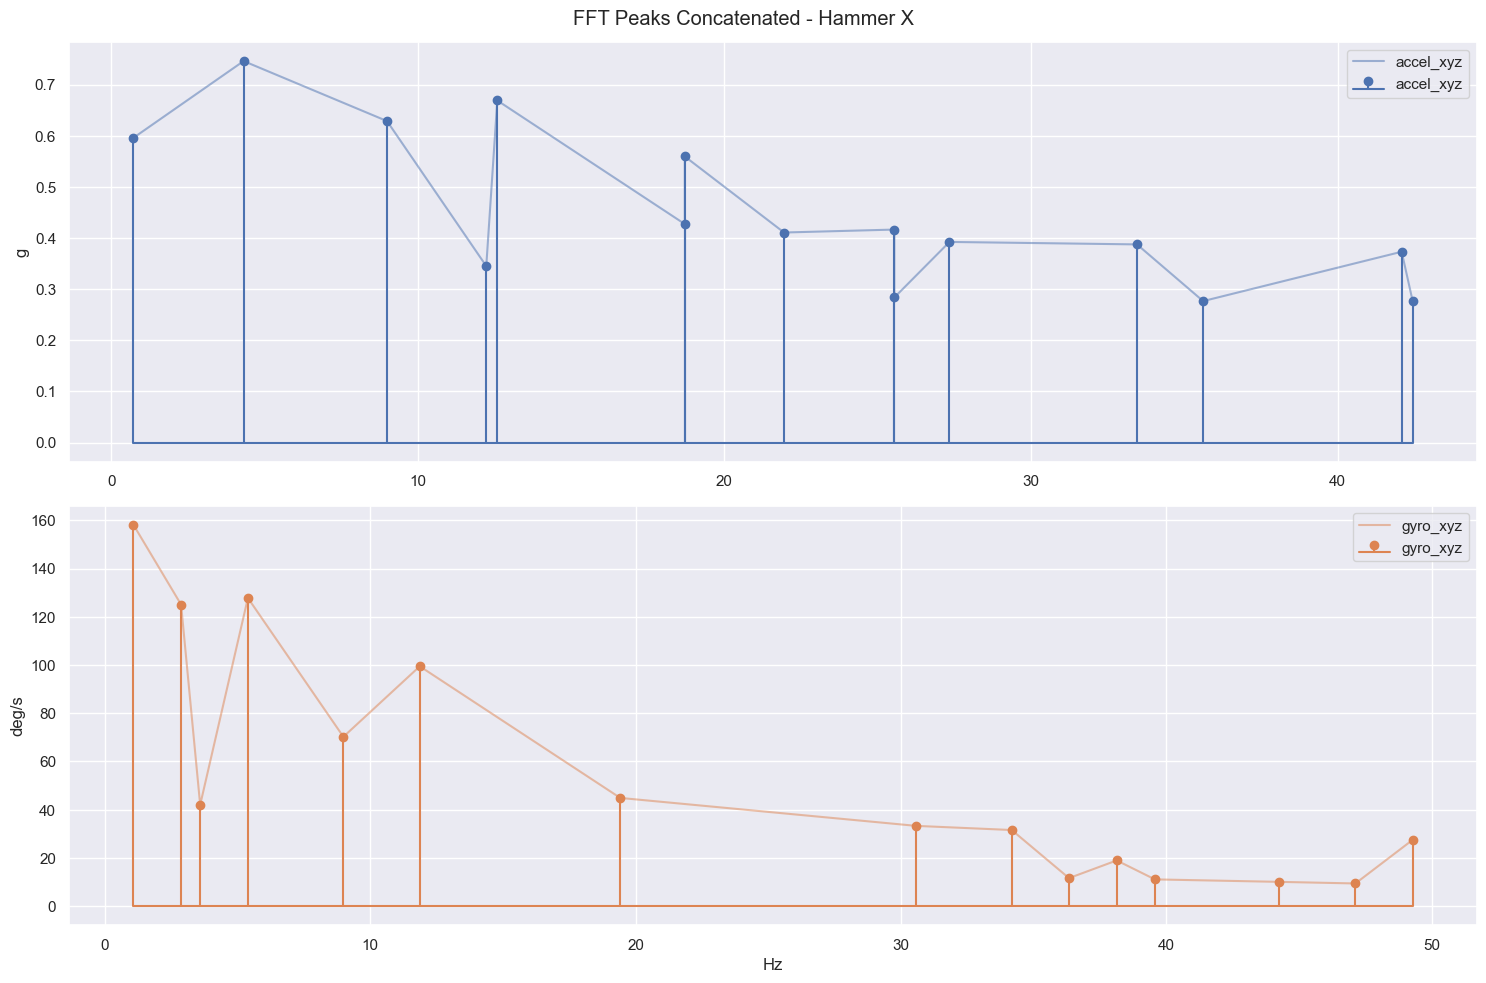

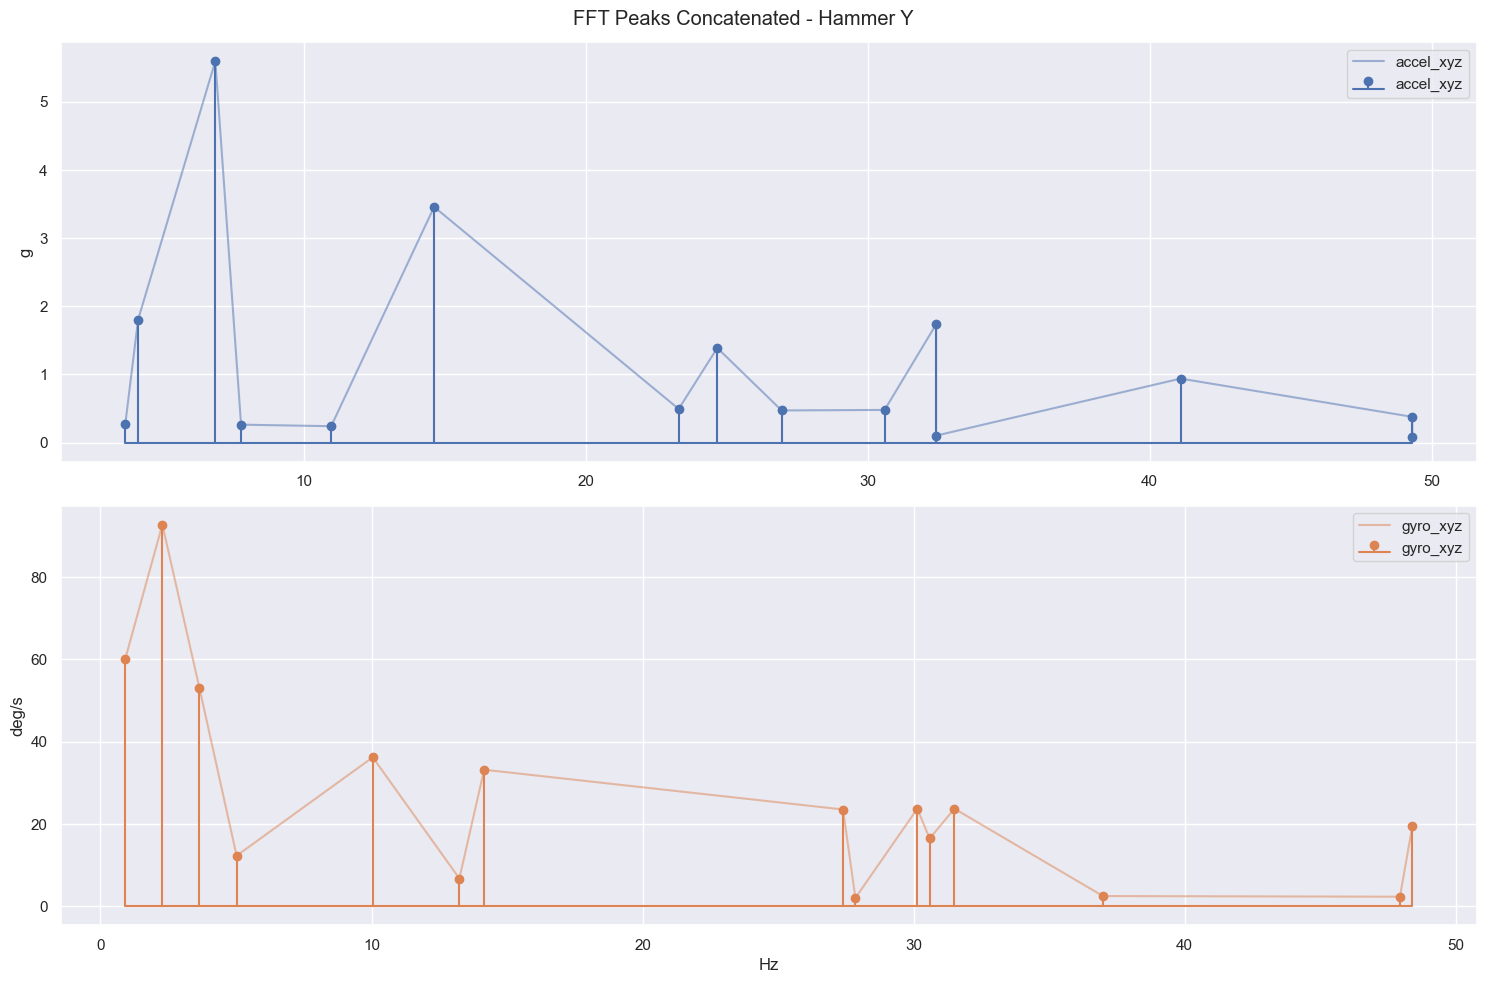

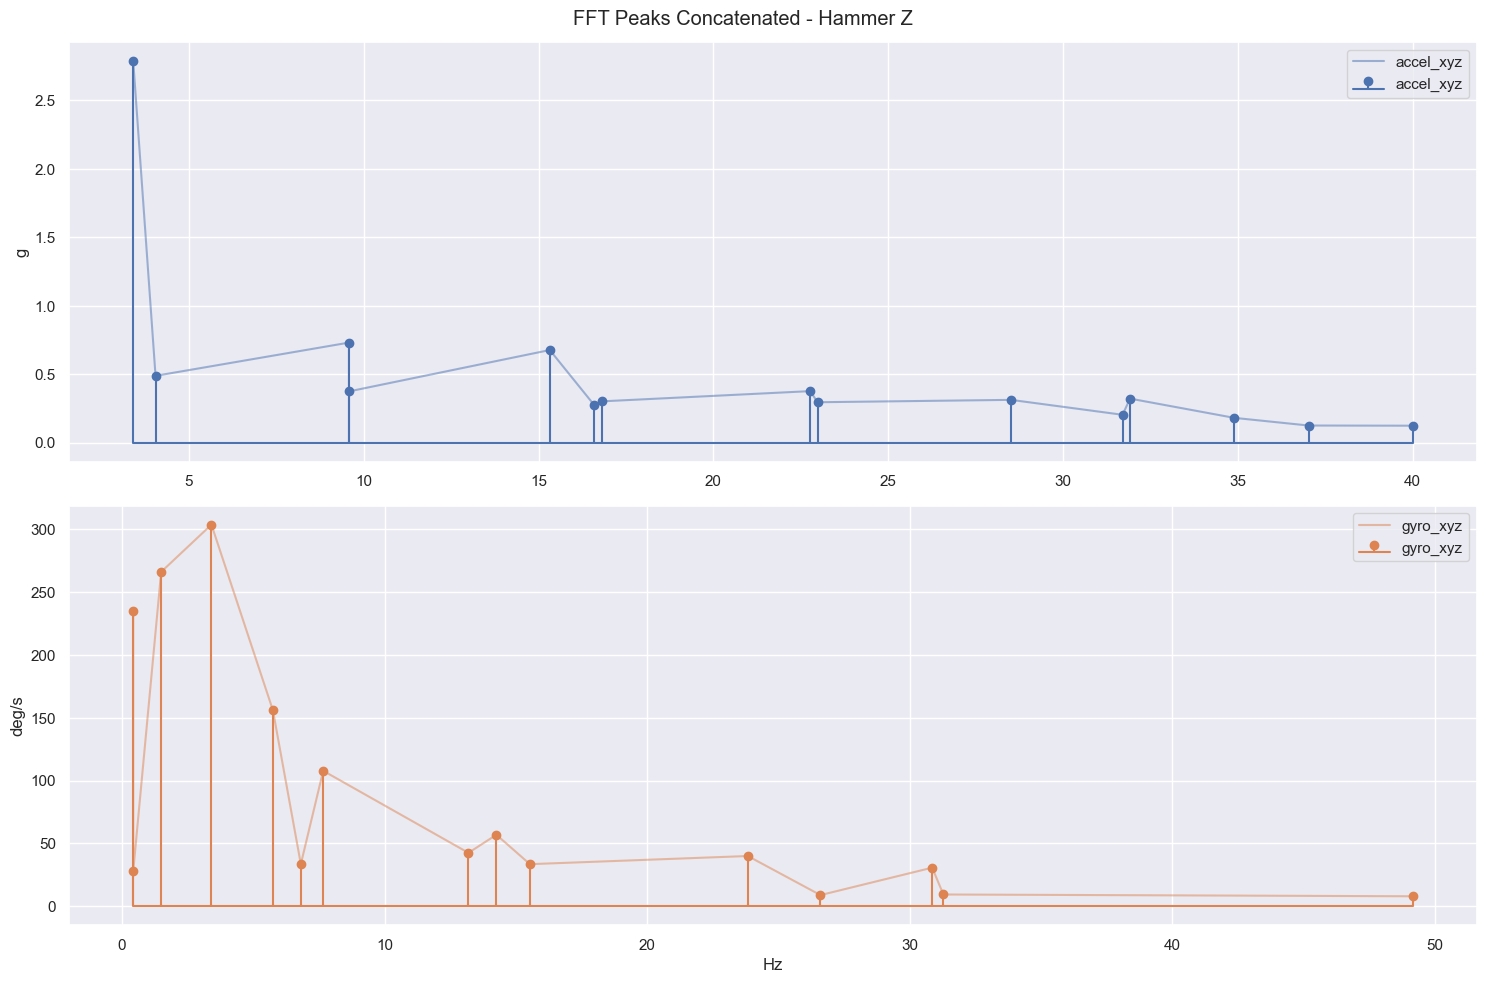

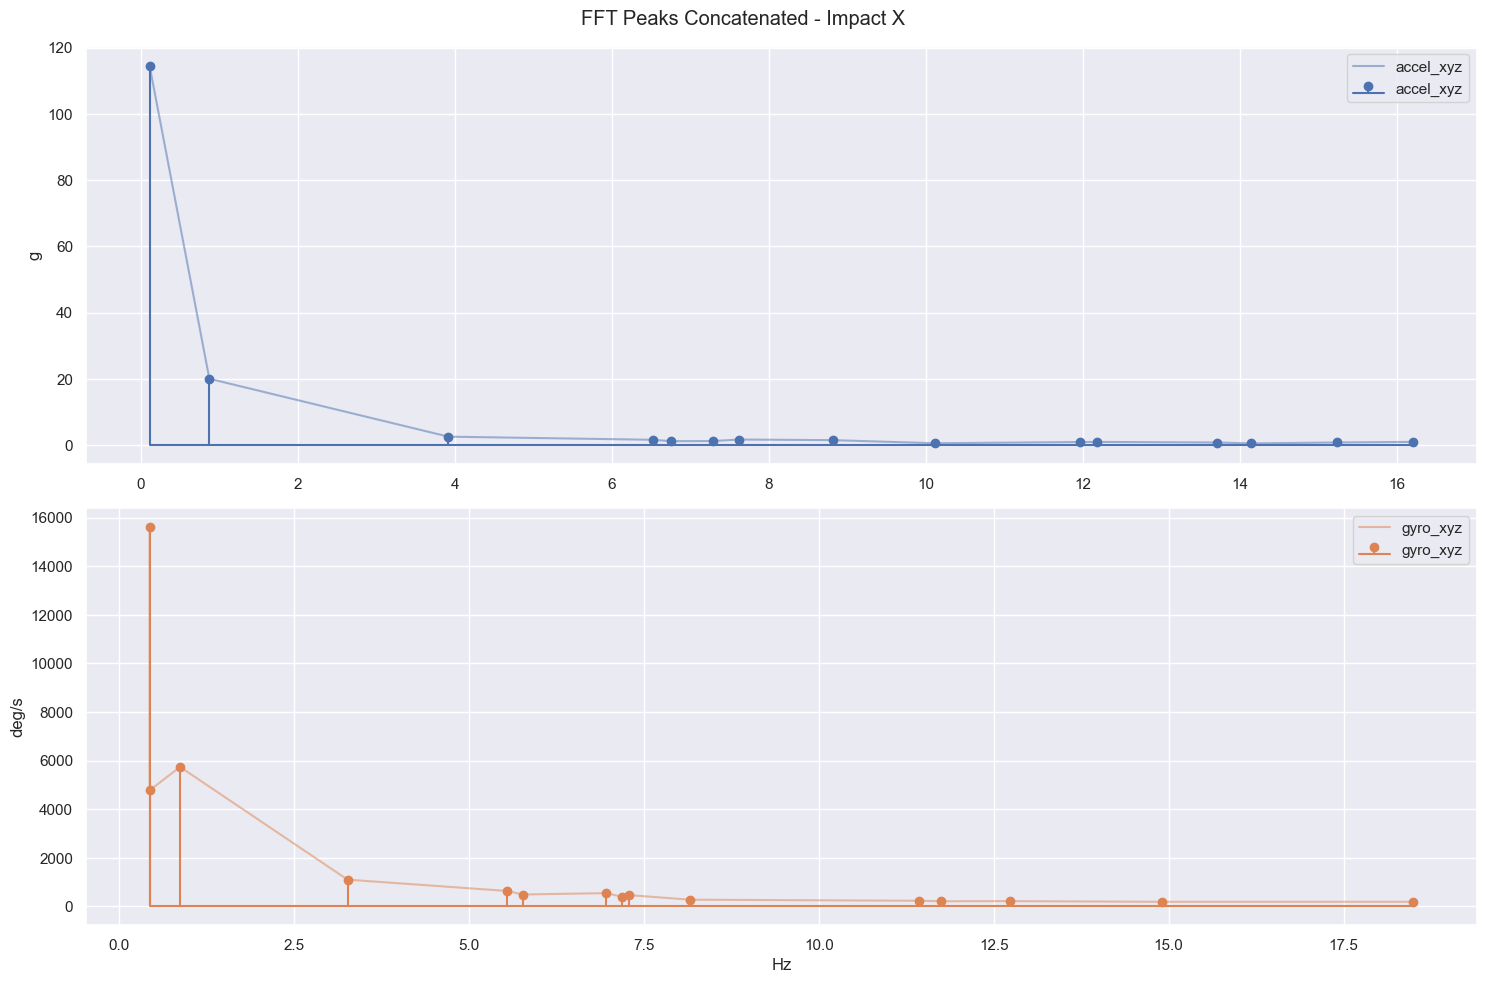

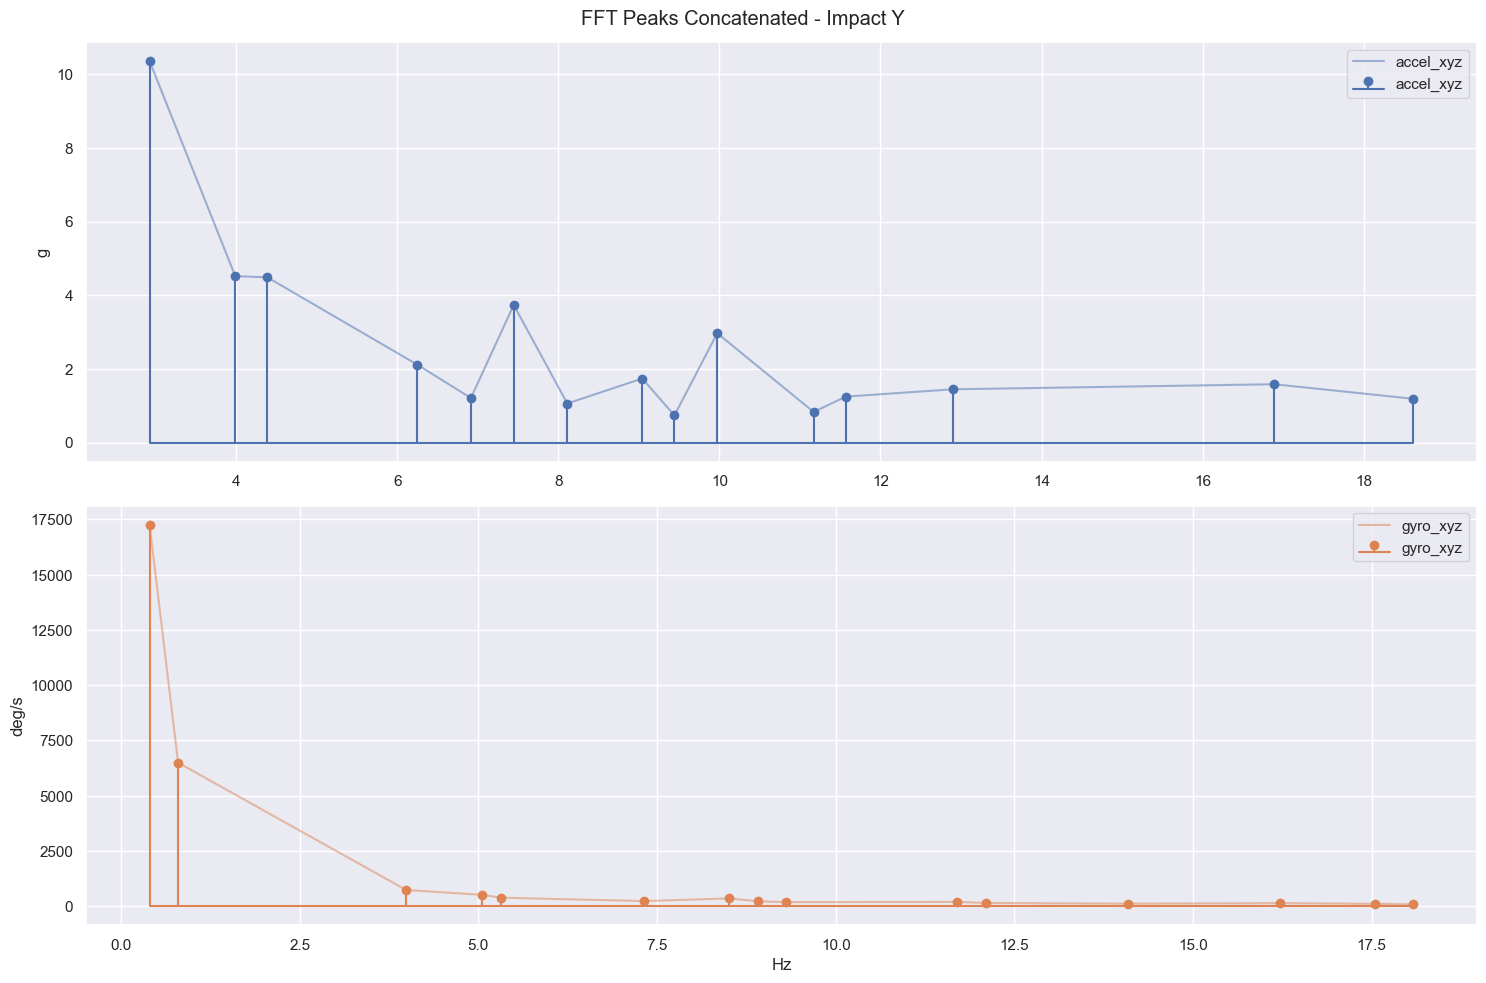

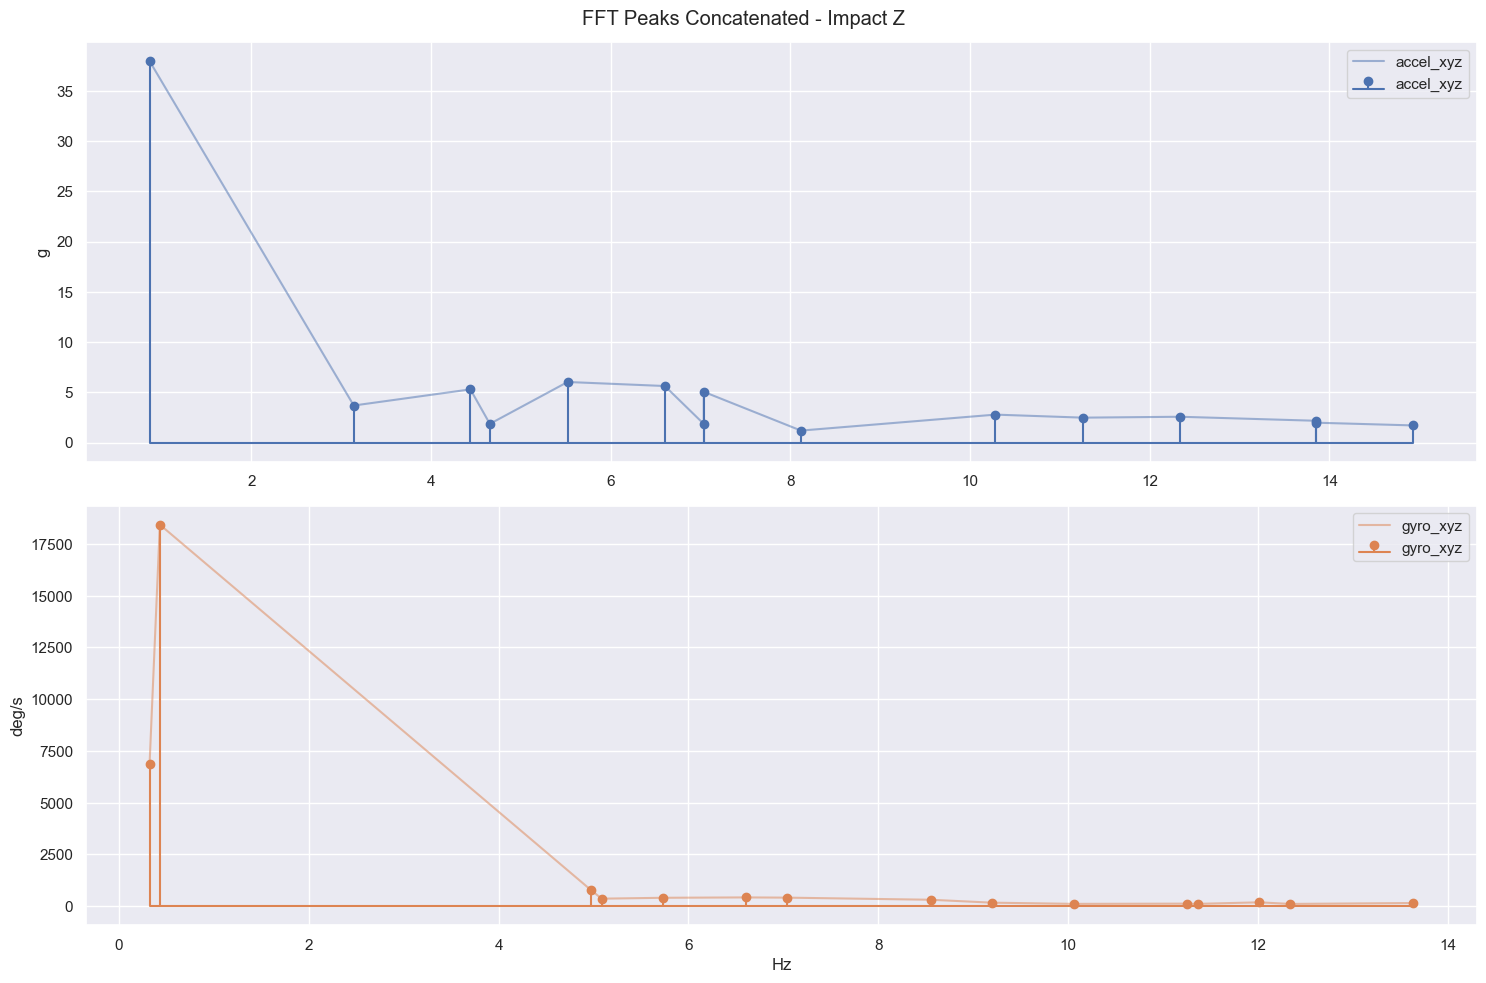

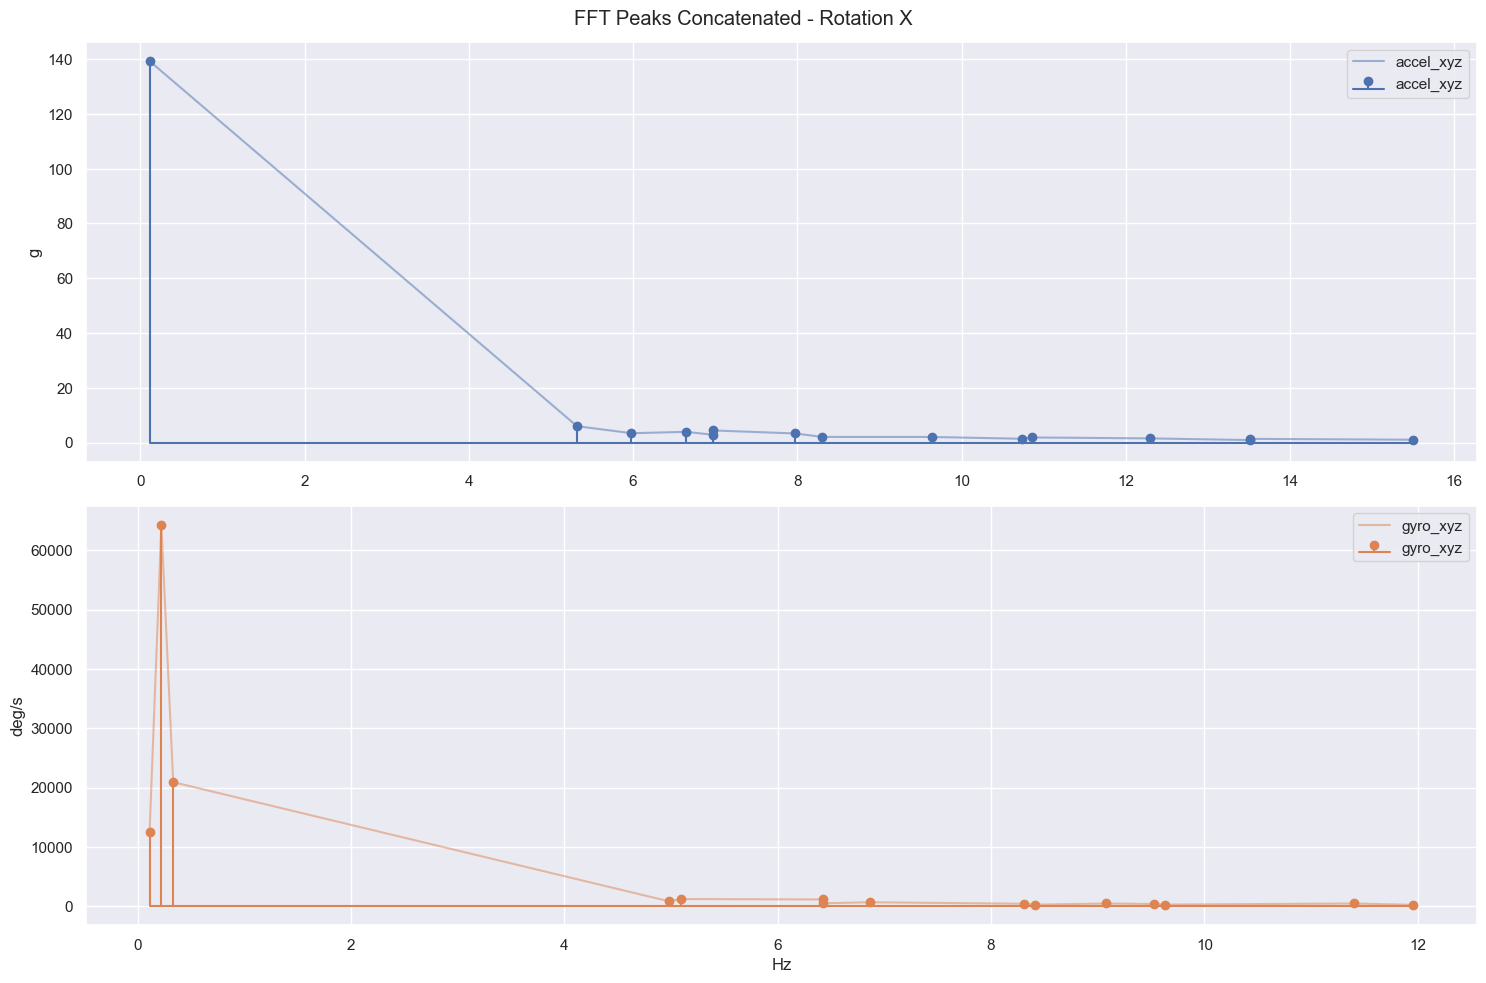

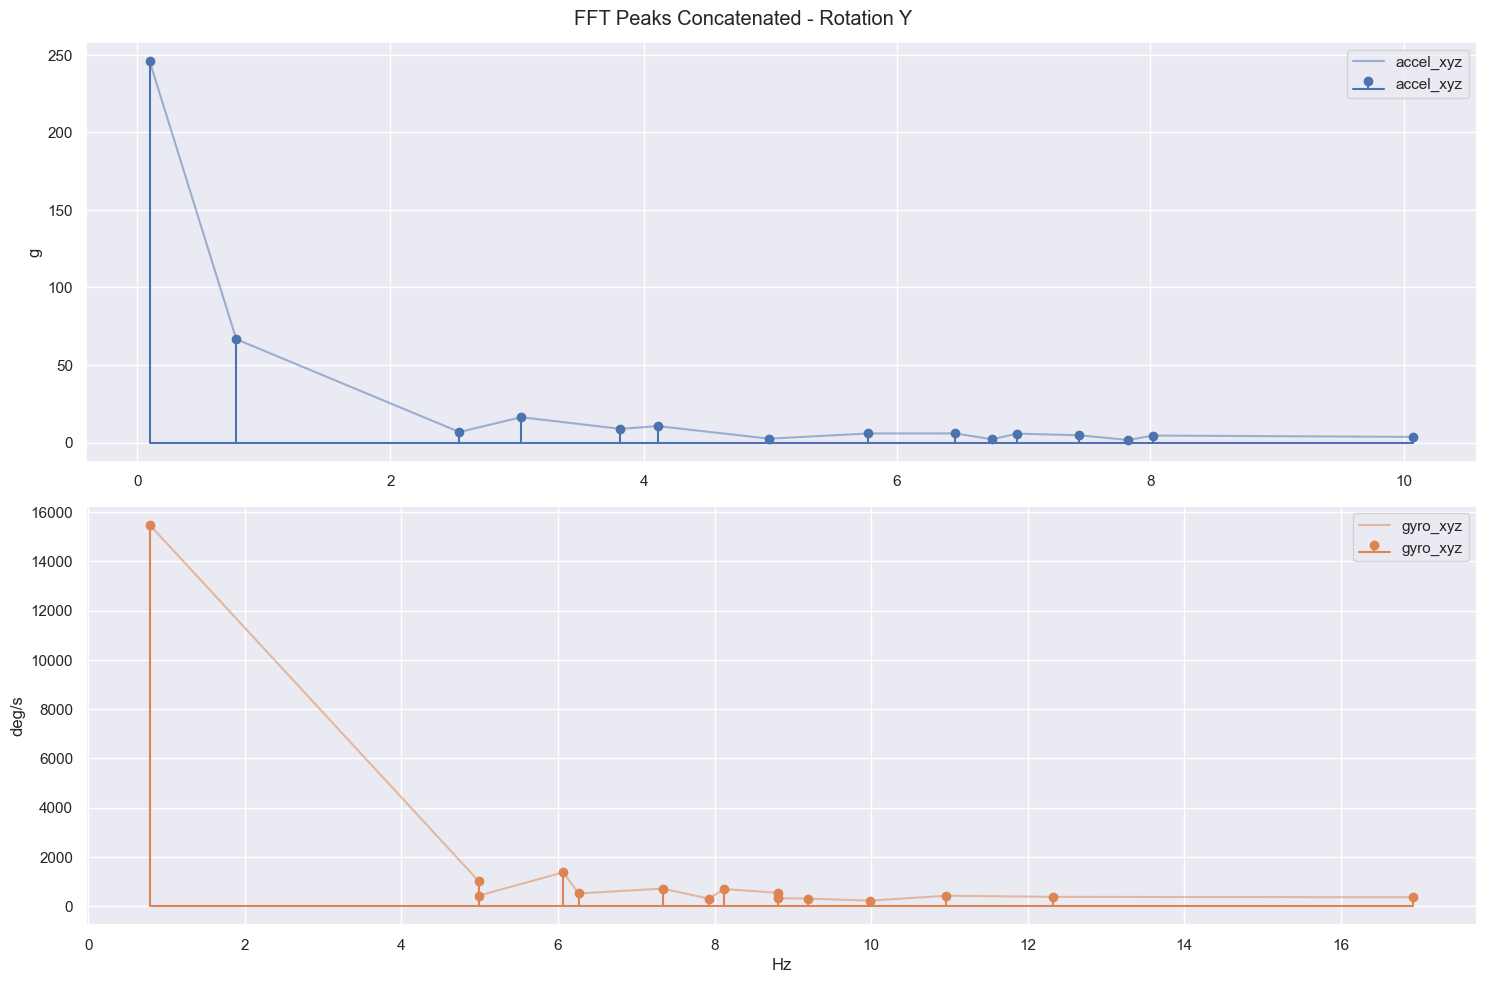

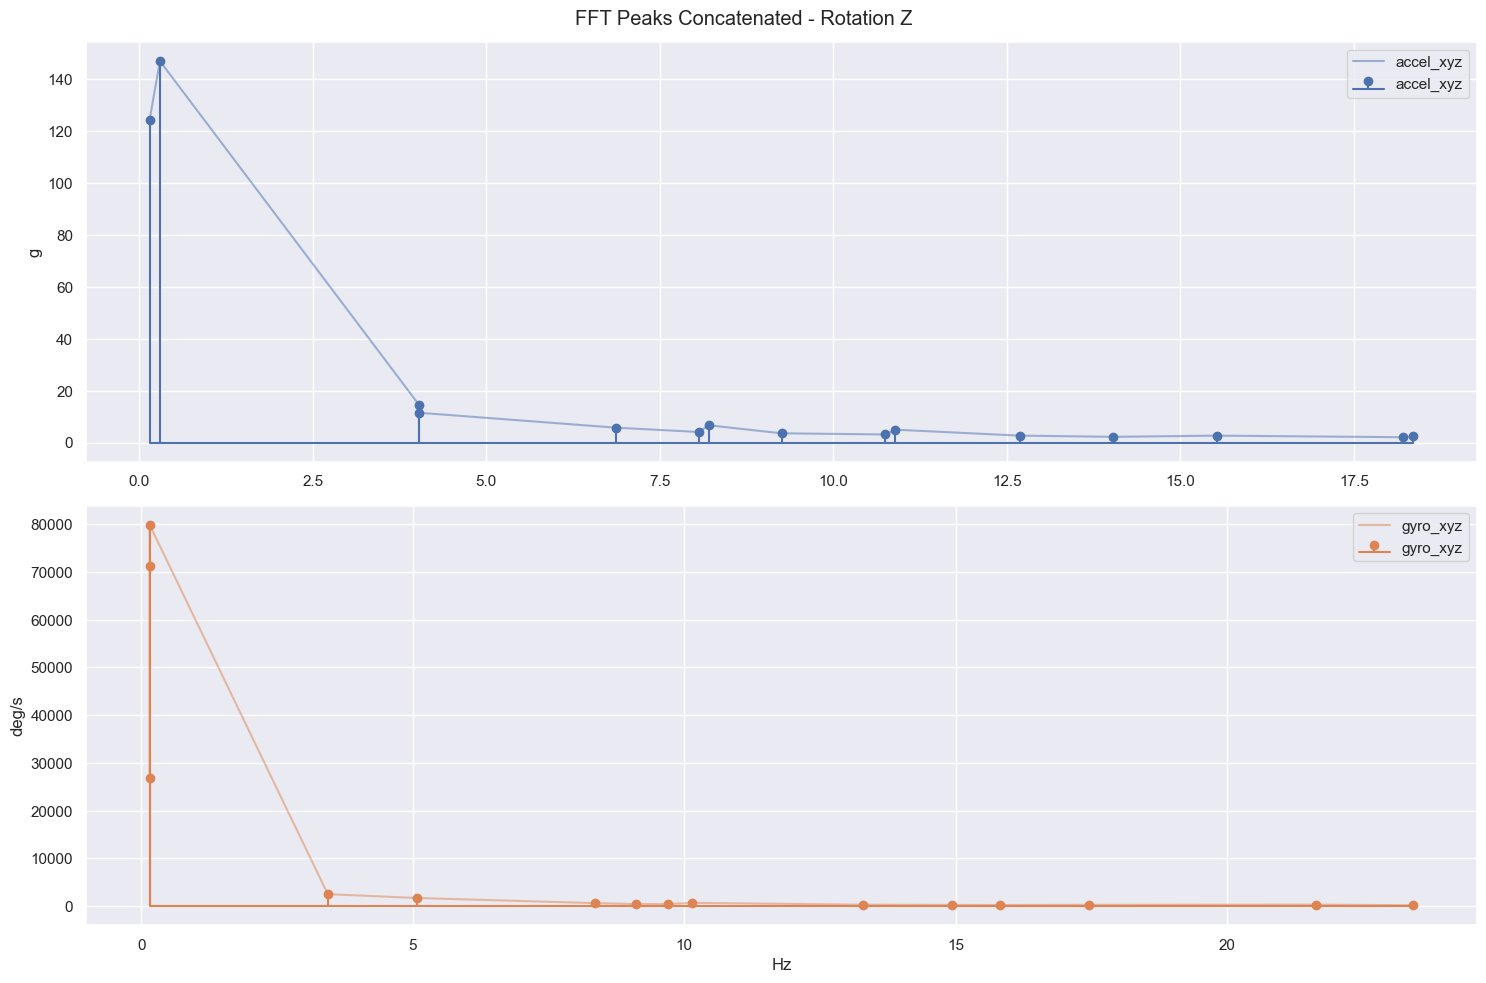

In [23]:
ref_accel, ref_gyro = plot_peaks_combined(ref_fft, title="Reference")
floatingx_accel, floatingx_gyro = plot_peaks_combined(floatingx_fft, title="Floating X")
floatingy_accel, floatingy_gyro = plot_peaks_combined(floatingy_fft, title="Floating Y")
floatingz_accel, floatingz_gyro = plot_peaks_combined(floatingz_fft, title="Floating Z")
hammerx_accel, hammerx_gyro = plot_peaks_combined(hammerx_fft, title="Hammer X")
hammery_accel, hammery_gyro = plot_peaks_combined(hammery_fft, title="Hammer Y")
hammerz_accel, hammerz_gyro = plot_peaks_combined(hammerz_fft, title="Hammer Z")
impactx_accel, impactx_gyro = plot_peaks_combined(impactx_fft, title="Impact X")
impacty_accel, impacty_gyro = plot_peaks_combined(impacty_fft, title="Impact Y")
impactz_accel, impactz_gyro = plot_peaks_combined(impactz_fft, title="Impact Z")
rotationx_accel, rotationx_gyro = plot_peaks_combined(rotationx_fft, title="Rotation X")
rotationy_accel, rotationy_gyro = plot_peaks_combined(rotationy_fft, title="Rotation Y")
rotationz_accel, rotationz_gyro = plot_peaks_combined(rotationz_fft, title="Rotation Z")

In [65]:
s1

array([0.01587302, 0.15873016, 0.17460317, 0.3015873 , 0.47619048,
       0.58730159, 0.66666667, 0.68253968, 0.80952381, 0.93650794,
       0.95238095, 1.15873016, 1.33333333, 1.47619048, 1.66666667])

DTW distance is: 14.658297709644835


(<Figure size 1000x1000 with 4 Axes>, [<Axes: >, <Axes: >, <Axes: >, <Axes: >])

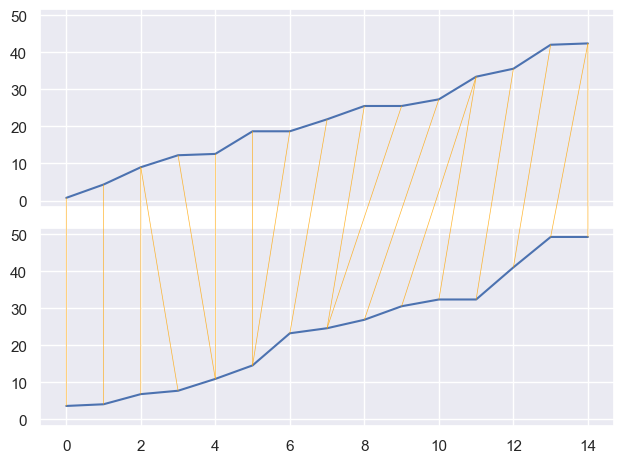

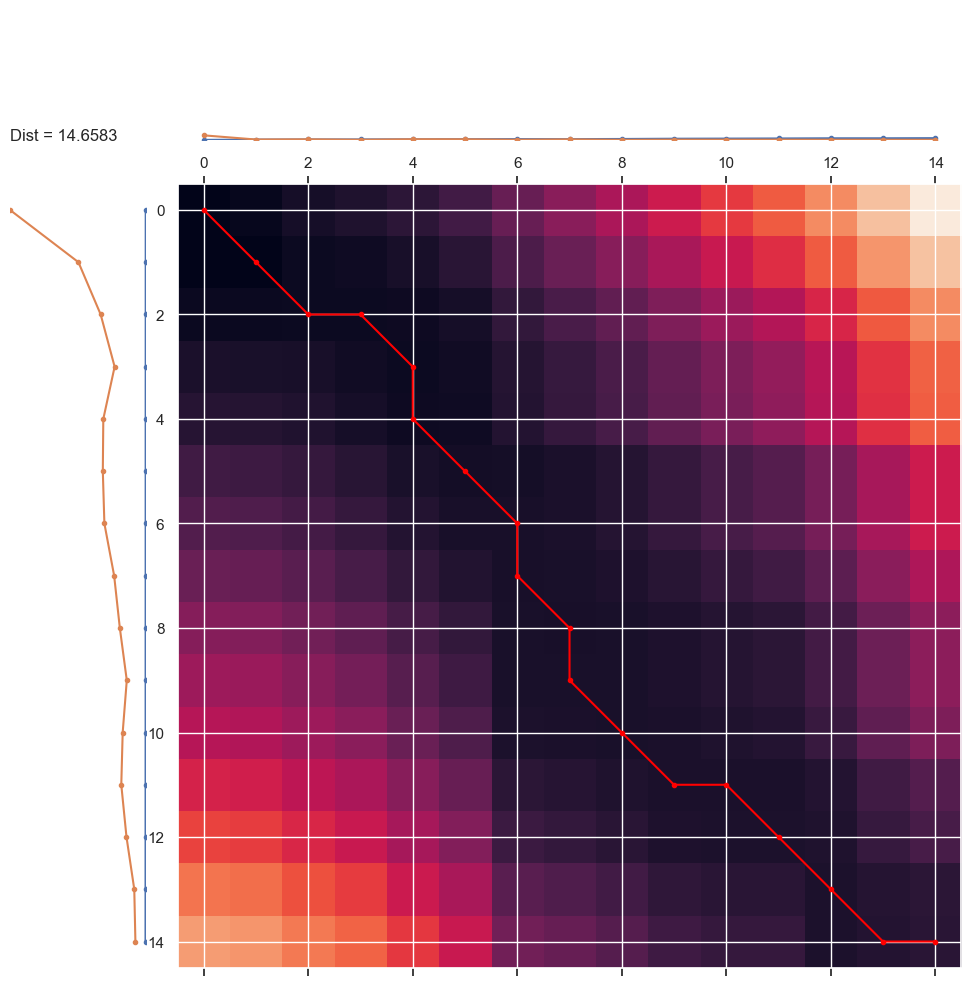

In [73]:
# Calculate the DTW distance between the two sequences
distance = dtw_ndim.distance(hammerx_accel, hammery_accel)
print("DTW distance is:", distance)
# s1 take only first column of the array
s1 = hammerx_accel[:,0]
s2 = hammery_accel[:,0]
single_path = dtw.warping_path(s1, s2)
dtwvis.plot_warping(s1, s2, single_path)

# plot the warping path
d, paths = dtw_ndim.warping_paths(hammerx_accel, hammery_accel)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(ref_accel, impactz_accel, paths, best_path)

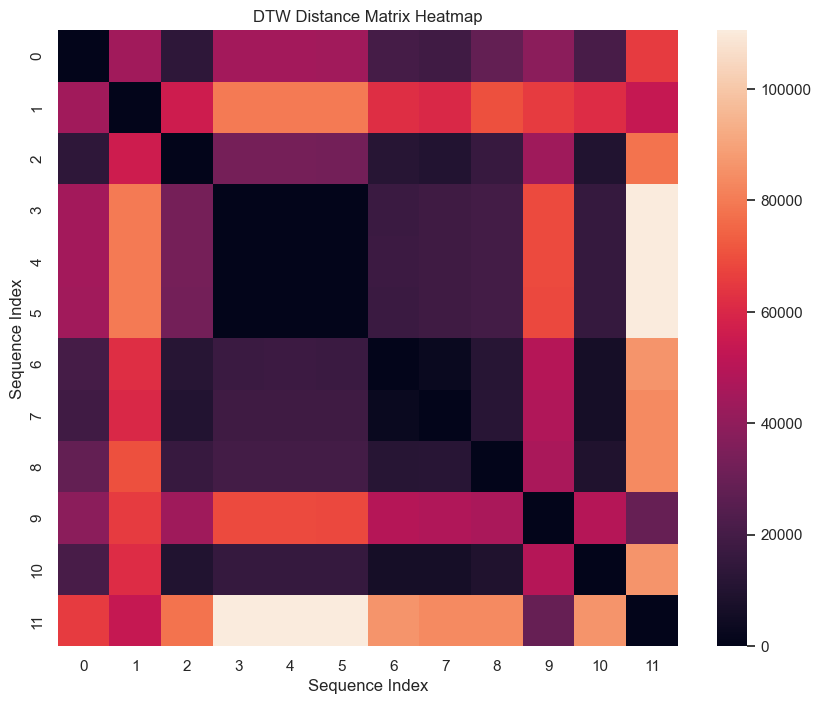

In [35]:
sequences = [
    floatingx_accel, floatingx_gyro, floatingy_accel, floatingy_gyro,
    floatingz_accel, floatingz_gyro, hammerx_accel, hammerx_gyro,
    hammery_accel, hammery_gyro, hammerz_accel, hammerz_gyro,
    impactx_accel, impactx_gyro, impacty_accel, impacty_gyro,
    impactz_accel, impactz_gyro, rotationx_accel, rotationx_gyro,
    rotationy_accel, rotationy_gyro, rotationz_accel, rotationz_gyro
]

# Initialize a 12x12 matrix of zeros for the distances
distance_matrix = np.zeros((12, 12))

# Calculate the DTW distance between each pair of sequences
for i in range(12):
    for j in range(12):
        if i != j:  # No need to calculate when i == j since the distance is zero
            distance = dtw_ndim.distance(sequences[i*2], sequences[j*2])  # *2 for accel
            distance += dtw_ndim.distance(sequences[i*2+1], sequences[j*2+1])  # *2+1 for gyro
            distance_matrix[i, j] = distance

# Now, create a heatmap from the distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=False, fmt=".2f")
plt.title('DTW Distance Matrix Heatmap')
plt.xlabel('Sequence Index')
plt.ylabel('Sequence Index')
plt.show()